name? kizawa


anomaly


C:\Users\baseb\anaconda3\envs\kenkyu\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


,D2,DATE


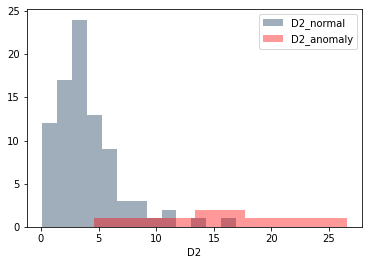

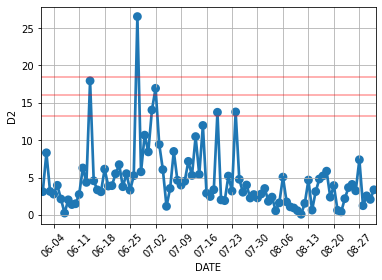

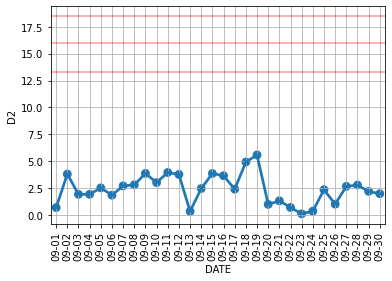

In [13]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from scipy.stats import chi2
import json
import matplotlib.dates as mdates

#標準化
def scal(x,y):
    scaler = StandardScaler()
    scaler.fit(x.iloc[:,1:-1])
    return scaler.transform(y.iloc[:,1:-1])

#相関行列の逆行列
def cor(x):
    corr = np.corrcoef(x.T)
    return np.linalg.inv(corr)

#マハラノビス汎距離
def mahara(x,y):
    df_D2 = pd.DataFrame(columns = ['D2'])
    for i in range(len(x)):
        a = np.dot(x[i],y)
        d2 = np.dot(a,x[i].T)
        df_D2 = df_D2.append({'D2':d2},ignore_index=True) 
    return df_D2

#名前入力
name = input('name?')

#異常データの取得
a = open('../.json/anomaly_day.json')
js = json.load(a)
an_days = js[name]

#単位空間
def unit_space(days):
    #trainデータ
    data_tr = pd.read_csv(f'../../data/{name}_train.csv',encoding = 'utf-8', parse_dates = ['日付'])
    data_tr = data_tr[['日付','項目名','値']]
    df = pd.pivot_table(data_tr,index = '日付',columns = '項目名',values = '値')
    df = df.reset_index()
    df = df.interpolate(axis=0) #欠損値の線形補間
    df = df.rename(columns = {'日付':'DATE'})
    df = df.drop(['【朝】体重', '【朝】睡眠時間'], axis=1) #間違って取得した変数の削除
    x_clm = df.columns.unique()

    #異常の日を定義
    df['怪我状態'] = 0
    for i in range(len(days)):
        df.loc[df['DATE'] == days[i] , '怪我状態'] = 1


    #normalデータとanomalyデータを作成
    normal = df[df['怪我状態'] == 0].reset_index(drop = True)
    anomaly = df[df['怪我状態'] == 1].reset_index(drop = True)

    #testデータ
    data_ts = pd.read_csv(f'../../data/{name}_test.csv',encoding = 'utf-8', parse_dates = ['日付'])
    data_ts = data_ts[['日付','項目名','値']]
    test = pd.pivot_table(data_ts,index = '日付',columns = '項目名',values = '値')
    test = test.reset_index()
    test = test.interpolate(axis=0) #線形補間
    test = test.rename(columns = {'日付':'DATE'})
    test = test.drop(['【朝】体重', '【朝】睡眠時間'], axis=1) #間違って取得した変数の削除
    test['怪我状態'] = 0

    #標準化
    scaled_nm = scal(normal,normal)
    scaled_an = scal(normal,anomaly) #異常データも正常データの平均と分散で標準化

    #相関行列の逆行列
    corr_inv = cor(scaled_nm) #正常データのΣ^―1

    #マハラノビス距離
    D2 = mahara(scaled_nm,corr_inv) / (len(x_clm)-1)
    D2['DATE'] = normal['DATE'] 

    return D2,test,scaled_nm,scaled_an,corr_inv,normal,anomaly,x_clm

#正常データに入っていた明らかな異常値をを単位空間から削除
D2,test,scaled_nm,scaled_an,corr_inv,normal,anomaly,x_clm = unit_space(an_days)
a = D2.loc[D2['D2']>3,'DATE'] #項目数で割ったマハラノビス距離が3以上のものを削除
an_days.extend(a.dt.strftime("%Y-%m-%d").to_list())

#新しい単位空間を作成
D2,test,scaled_nm,scaled_an,corr_inv,normal,anomaly,x_clm = unit_space(an_days)

#L8直行表
df_l8 = pd.DataFrame([[1,1,1,1,1,1,1],[1,1,1,2,2,2,2],[1,2,2,1,1,2,2],[1,2,2,2,2,1,1],[2,1,2,1,2,1,2],[2,1,2,2,1,2,1],[2,2,1,1,2,2,1],[2,2,1,2,1,1,2]])
l8 = (df_l8==1).values

#異常データのマハラノビス距離
result = np.zeros(shape=(l8.shape[0], scaled_an.shape[0]))
for x, l8_raw in enumerate(l8):
    for y, an_raw in enumerate(scaled_an):
        select_corr = corr_inv[l8_raw][:,l8_raw] #直交表で第一水準の項目のみでΣの逆行列
        select_raw = an_raw[l8_raw]
        result[x, y] = np.dot(np.dot(select_raw.reshape(1,-1), select_corr), select_raw) / sum(l8_raw)

#SN比
sn = np.zeros(l8.shape[0])
for idx, raw in enumerate(result):
    a = 0
    for i in range(len(raw)):
        a += 1/np.square(raw[i])
    sn[idx] = -10 * math.log10(a/len(raw))
sn_rate = pd.DataFrame(sn,columns = ['SN比'])

#変数選択
df_sn = pd.DataFrame(index = x_clm[1:],columns = ['SN比','残す'])
for i in range(len(x_clm[1:])):
    df_sn.loc[df_sn.index == x_clm[1+i] , 'SN比'] = sum(sn[l8.T[i]])-sum(sn[l8.T[i] == False])
    df_sn.loc[df_sn.index == x_clm[1+i] , '残す'] = sum(sn[l8.T[i]])-sum(sn[l8.T[i] == False])>0
select_v = df_sn.reset_index()

#変数削除
normal_d = normal.drop(columns=df_sn[df_sn['残す'] == False].index)
anomaly_d = anomaly.drop(columns=df_sn[df_sn['残す'] == False].index)
test_d = test.drop(columns=df_sn[df_sn['残す'] == False].index)

#標準化
scaled_normal_d = scal(normal_d,normal_d)
scaled_anomaly_d = scal(normal_d,anomaly_d)

#逆行列
corr_inv_d = cor(scaled_normal_d)

# 最終的な単位空間からのマハラノビス距離
D2_normal_d = mahara(scaled_normal_d,corr_inv_d)
D2_normal_d['DATE'] = normal['DATE']

print('anomaly')
D2_anomaly_d = mahara(scaled_anomaly_d,corr_inv_d)
D2_anomaly_d['DATE'] = anomaly['DATE']

with pd.ExcelWriter(f"../../result/{name}_result.xlsx") as writer:
    sn_rate.to_excel(writer, sheet_name='sheet1')
    select_v.to_excel(writer, sheet_name='sheet2')
    D2_anomaly_d.to_excel(writer, sheet_name='sheet3')

#ヒストグラム
fig = plt.figure()
ax1 = sns.distplot(
    D2_normal_d['D2'], label='D2_normal',color='#123456',
    kde=False,
    rug=False)
ax2 = sns.distplot(
    D2_anomaly_d['D2'], label='D2_anomaly',color = 'red',
    kde=False,
    rug=False )
plt.legend() 
fig.savefig(f"../../result/{name}_hist.png")

#χ2検定の棄却域
kai_0_1 = chi2.ppf(q = 0.999,df = df_sn['残す'].sum())
kai_0_3 = chi2.ppf(q = 0.997,df = df_sn['残す'].sum())
kai_1 = chi2.ppf(q = 0.99,df = df_sn['残す'].sum()) 
kai_5 = chi2.ppf(q = 0.95,df = df_sn['残す'].sum()) 

#trainデータのT²管理図
#print('trainデータのT²管理図')
D2_train_df = pd.concat([D2_normal_d,D2_anomaly_d])
D2_train_df = D2_train_df.sort_values(['DATE'])
fig = plt.figure()
ax = sns.pointplot(x = 'DATE',y = 'D2',data = D2_train_df)
ax.set_xticklabels(D2_train_df["DATE"].dt.strftime("%m-%d"))
ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=None, interval=7, tz=None))
plt.xticks(rotation = 45)
ax.axhline(y = kai_0_1, linewidth=2, color="red",alpha=0.3)
ax.axhline(y = kai_0_3, linewidth=2, color="red",alpha=0.3)
ax.axhline(y = kai_1, linewidth=2, color="red",alpha=0.3)
# ax.axhline(y = kai_5, linewidth=2, color="red",alpha=0.3)
ax.grid()
fig.savefig(f"../../result/{name}_train.png")

#0.1%
#print("0.1%有意")
D2_train_df[D2_train_df['D2'] > kai_0_1]

#0.3%
#print("0.3%有意")
D2_train_df[(D2_train_df['D2'] > kai_0_3) & (D2_train_df['D2'] < kai_0_1)]

#1%
#print("1%有意")
D2_train_df[(D2_train_df['D2'] > kai_1) & (D2_train_df['D2'] < kai_0_3)]

# #5%
# print("5%有意")
# display(D2_train_df[(D2_train_df['D2'] > kai_5) & (D2_train_df['D2'] < kai_1)])


#testデータのT²管理図
scaled_test = scal(normal_d,test_d)
D2_test = mahara(scaled_test,corr_inv_d)
D2_test['DATE'] = test['DATE']
#print('testデータのT²管理図')
fig = plt.figure()
ax = sns.pointplot(x = 'DATE',y = 'D2',data = D2_test)
ax.set_xticklabels(D2_test["DATE"].dt.strftime("%m-%d"))
ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=None, interval=1, tz=None))
plt.xticks(rotation = 90)
ax.axhline(y = kai_0_1, linewidth=2, color="red",alpha=0.3)
ax.axhline(y = kai_0_3, linewidth=2, color="red",alpha=0.3)
ax.axhline(y = kai_1, linewidth=2, color="red",alpha=0.3)
#ax.axhline(y = kai_5, linewidth=2, color="red",alpha=0.3)
ax.grid()
fig.savefig(f"../../result/{name}_test.png")

#0.1%
# print("0.1%有意")
D2_test[D2_test['D2'] > kai_0_1]

#0.3%
# print("0.3%有意")
D2_test[(D2_test['D2'] > kai_0_3) & (D2_test['D2'] < kai_0_1)]

#1%
# print("1%有意")
D2_test[(D2_test['D2'] > kai_1) & (D2_test['D2'] < kai_0_3)]

# #5%
# print("5%有意")
# display(D2_test[(D2_test['D2'] > kai_5) & (D2_test['D2'] < kai_1)])



name? sekine


,SN比
0,10.064223
1,-8.771732
2,-7.148740
3,16.906126
4,5.861287
5,14.995380
6,14.115554
7,7.660049


,項目名,SN比,残す
0,【全員共通】疲労度,-31.5824,False
1,【朝】下肢の状態,-9.38383,False
2,【朝】体幹の状態,-7.54596,False
3,【朝】疲労度,-7.8975,False
4,【朝】睡眠の質,-2.54032,False
5,【朝】肘の状態,27.3012,True
6,【朝】肩の状態,58.4804,True


anomaly


,D2,DATE
0,11.072702,2020-07-05
1,13.130028,2020-07-31
2,19.950406,2020-08-04
3,14.457614,2020-08-11
4,14.457614,2020-08-12
5,14.962628,2020-08-17


C:\Users\baseb\anaconda3\envs\kenkyu\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


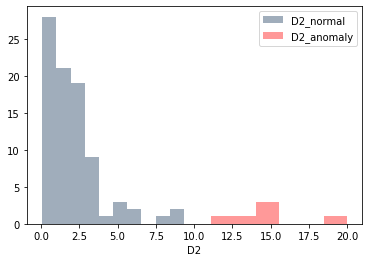

trainデータのT²管理図


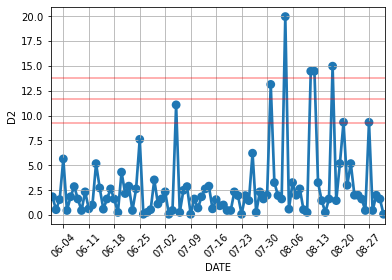

0.1%有意


,D2,DATE
2,19.950406,2020-08-04
3,14.457614,2020-08-11
4,14.457614,2020-08-12
5,14.962628,2020-08-17


0.3%有意


,D2,DATE
1,13.130028,2020-07-31


1%有意


,D2,DATE
0,11.072702,2020-07-05
74,9.328406,2020-08-20
81,9.318886,2020-08-27


testデータのT²管理図


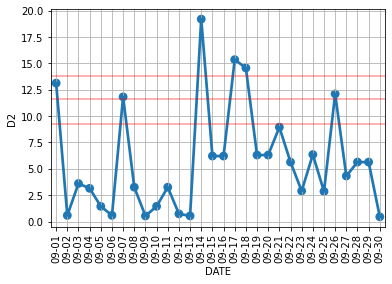

0.1%有意


,D2,DATE
13,19.197307,2020-09-14
16,15.353417,2020-09-17
17,14.567328,2020-09-18


0.3%有意


,D2,DATE
0,13.130028,2020-09-01
6,11.823704,2020-09-07
25,12.108172,2020-09-26


1%有意


,D2,DATE


In [1]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from scipy.stats import chi2
import json
import matplotlib.dates as mdates

#標準化
def scal(x,y):
    scaler = StandardScaler()
    scaler.fit(x.iloc[:,1:-1])
    return scaler.transform(y.iloc[:,1:-1])

#逆行列
def cor(x):
    corr = np.corrcoef(x.T)
    return np.linalg.inv(corr)

def mahara(x,y):
    df_D2 = pd.DataFrame(columns = ['D2'])
    for i in range(len(x)):
        a = np.dot(x[i],y)
        d2 = np.dot(a,x[i].T)
        df_D2 = df_D2.append({'D2':d2},ignore_index=True) 
    return df_D2

#データの取得
name = input('name?')
a = open('../.json/anomaly_day.json')
js = json.load(a)
an_days = js[name]

def unit_space(days):
    #trainデータ
    data_tr = pd.read_csv(f'../../data/{name}_train.csv',encoding = 'utf-8', parse_dates = ['日付'])
    data_tr = data_tr[['日付','項目名','値']]
    df = pd.pivot_table(data_tr,index = '日付',columns = '項目名',values = '値')
    df = df.reset_index()
    df = df.interpolate(axis=0)
    df = df.rename(columns = {'日付':'DATE'})
    df = df.drop(['【朝】体重', '【朝】睡眠時間'], axis=1)
    x_clm = df.columns.unique()

    #異常の日を設定
    df['怪我状態'] = 0
    for i in range(len(days)):
        df.loc[df['DATE'] == days[i] , '怪我状態'] = 1


    #normalデータとanomalyデータを作成
    normal = df[df['怪我状態'] == 0].reset_index(drop = True)
    anomaly = df[df['怪我状態'] == 1].reset_index(drop = True)

    #testデータ
    data_ts = pd.read_csv(f'../../data/{name}_test.csv',encoding = 'utf-8', parse_dates = ['日付'])
    data_ts = data_ts[['日付','項目名','値']]
    test = pd.pivot_table(data_ts,index = '日付',columns = '項目名',values = '値')
    test = test.reset_index()
    test = test.interpolate(axis=0)
    test = test.rename(columns = {'日付':'DATE'})
    test = test.drop(['【朝】体重', '【朝】睡眠時間'], axis=1)
    test['怪我状態'] = 0

    #標準化
    scaled_nm = scal(normal,normal)
    scaled_an = scal(normal,anomaly)

    #逆行列
    corr_inv = cor(scaled_nm)

    #マハラノビス距離
    D2 = mahara(scaled_nm,corr_inv) / (len(x_clm)-1)
    D2['DATE'] = normal['DATE']  #ここから異常値を削除して元に戻りたい

    return D2,test,scaled_nm,scaled_an,corr_inv,normal,anomaly,x_clm

#異常値を単位空間から削除
D2,test,scaled_nm,scaled_an,corr_inv,normal,anomaly,x_clm = unit_space(an_days)
a = D2.loc[D2['D2']>3,'DATE']
an_days.extend(a.dt.strftime("%Y-%m-%d").to_list())

#新しい単位空間を作成
D2,test,scaled_nm,scaled_an,corr_inv,normal,anomaly,x_clm = unit_space(an_days)

#L8直行表
df_l8 = pd.DataFrame([[1,1,1,1,1,1,1],[1,1,1,2,2,2,2],[1,2,2,1,1,2,2],[1,2,2,2,2,1,1],[2,1,2,1,2,1,2],[2,1,2,2,1,2,1],[2,2,1,1,2,2,1],[2,2,1,2,1,1,2]])
l8 = (df_l8==1).values

#各異常値のマハラノビス距離
result = np.zeros(shape=(l8.shape[0], scaled_an.shape[0]))
for x, l8_raw in enumerate(l8):
    for y, an_raw in enumerate(scaled_an):
        select_corr = corr_inv[l8_raw][:,l8_raw]
        select_raw = an_raw[l8_raw]
        result[x, y] = np.dot(np.dot(select_raw.reshape(1,-1), select_corr), select_raw) / sum(l8_raw)

#SN比
sn = np.zeros(l8.shape[0])
for idx, raw in enumerate(result):
    a = 0
    for i in range(len(raw)):
        a += 1/np.square(raw[i])
    sn[idx] = -10 * math.log10(a/len(raw))
display(pd.DataFrame(sn,columns = ['SN比']))

#変数選択
df_sn = pd.DataFrame(index = x_clm[1:],columns = ['SN比','残す'])
for i in range(len(x_clm[1:])):
    df_sn.loc[df_sn.index == x_clm[1+i] , 'SN比'] = sum(sn[l8.T[i]])-sum(sn[l8.T[i] == False])
    df_sn.loc[df_sn.index == x_clm[1+i] , '残す'] = sum(sn[l8.T[i]])-sum(sn[l8.T[i] == False])>0
display(df_sn.reset_index())

#変数削除
normal_d = normal.drop(columns=df_sn[df_sn['残す'] == False].index)
anomaly_d = anomaly.drop(columns=df_sn[df_sn['残す'] == False].index)
test_d = test.drop(columns=df_sn[df_sn['残す'] == False].index)

#標準化
scaled_normal_d = scal(normal_d,normal_d)
scaled_anomaly_d = scal(normal_d,anomaly_d)

#逆行列
corr_inv_d = cor(scaled_normal_d)

# 最終的な単位空間からのマハラノビス距離
D2_normal_d = mahara(scaled_normal_d,corr_inv_d)
D2_normal_d['DATE'] = normal['DATE']

print('anomaly')
D2_anomaly_d = mahara(scaled_anomaly_d,corr_inv_d)
D2_anomaly_d['DATE'] = anomaly['DATE']
display(D2_anomaly_d)

#ヒストグラム
ax1 = sns.distplot(
    D2_normal_d['D2'], label='D2_normal',color='#123456',
    kde=False,
    rug=False)
ax2 = sns.distplot(
    D2_anomaly_d['D2'], label='D2_anomaly',color = 'red',
    kde=False,
    rug=False )
plt.legend() 
plt.show()

#χ2検定の棄却域
kai_0_1 = chi2.ppf(q = 0.999,df = df_sn['残す'].sum())
kai_0_3 = chi2.ppf(q = 0.997,df = df_sn['残す'].sum())
kai_1 = chi2.ppf(q = 0.99,df = df_sn['残す'].sum()) 
kai_5 = chi2.ppf(q = 0.95,df = df_sn['残す'].sum()) 

#trainデータのT²管理図
print('trainデータのT²管理図')
D2_train_df = pd.concat([D2_normal_d,D2_anomaly_d])
D2_train_df = D2_train_df.sort_values(['DATE'])
ax = sns.pointplot(x = 'DATE',y = 'D2',data = D2_train_df)
ax.set_xticklabels(D2_train_df["DATE"].dt.strftime("%m-%d"))
ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=None, interval=7, tz=None))
plt.xticks(rotation = 45)
ax.axhline(y = kai_0_1, linewidth=2, color="red",alpha=0.3)
ax.axhline(y = kai_0_3, linewidth=2, color="red",alpha=0.3)
ax.axhline(y = kai_1, linewidth=2, color="red",alpha=0.3)
# ax.axhline(y = kai_5, linewidth=2, color="red",alpha=0.3)
ax.grid()
plt.show()

#0.1%
print("0.1%有意")
display(D2_train_df[D2_train_df['D2'] > kai_0_1])

#0.3%
print("0.3%有意")
display(D2_train_df[(D2_train_df['D2'] > kai_0_3) & (D2_train_df['D2'] < kai_0_1)])

#1%
print("1%有意")
display(D2_train_df[(D2_train_df['D2'] > kai_1) & (D2_train_df['D2'] < kai_0_3)])

# #5%
# print("5%有意")
# display(D2_train_df[(D2_train_df['D2'] > kai_5) & (D2_train_df['D2'] < kai_1)])


#testデータのT²管理図
scaled_test = scal(normal_d,test_d)
D2_test = mahara(scaled_test,corr_inv_d)
D2_test['DATE'] = test['DATE']
print('testデータのT²管理図')
ax = sns.pointplot(x = 'DATE',y = 'D2',data = D2_test)
ax.set_xticklabels(D2_test["DATE"].dt.strftime("%m-%d"))
ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=None, interval=1, tz=None))
plt.xticks(rotation = 90)
ax.axhline(y = kai_0_1, linewidth=2, color="red",alpha=0.3)
ax.axhline(y = kai_0_3, linewidth=2, color="red",alpha=0.3)
ax.axhline(y = kai_1, linewidth=2, color="red",alpha=0.3)
#ax.axhline(y = kai_5, linewidth=2, color="red",alpha=0.3)
ax.grid()
plt.show()

#0.1%
print("0.1%有意")
display(D2_test[D2_test['D2'] > kai_0_1])

#0.3%
print("0.3%有意")
display(D2_test[(D2_test['D2'] > kai_0_3) & (D2_test['D2'] < kai_0_1)])

#1%
print("1%有意")
display(D2_test[(D2_test['D2'] > kai_1) & (D2_test['D2'] < kai_0_3)])

# #5%
# print("5%有意")
# display(D2_test[(D2_test['D2'] > kai_5) & (D2_test['D2'] < kai_1)])



name? sato


,SN比
0,9.523060
1,-15.498164
2,-17.595192
3,9.316030
4,5.911553
5,-2.906411
6,-1.330471
7,4.375275


,項目名,SN比,残す
0,【全員共通】疲労度,-20.3042,False
1,【朝】下肢の状態,2.2644,True
2,【朝】体幹の状態,2.34372,True
3,【朝】疲労度,1.22222,True
4,【朝】睡眠の質,-5.00222,False
5,【朝】肘の状態,66.4562,True
6,【朝】肩の状態,37.4087,True


anomaly


,D2,DATE
0,9.785067,2020-06-14
1,72.824997,2020-06-27
2,45.719936,2020-06-28
3,15.058358,2020-06-29
4,34.677071,2020-07-30
5,26.471849,2020-07-31
6,8.261573,2020-08-02
7,30.325896,2020-08-28


C:\Users\baseb\anaconda3\envs\kenkyu\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


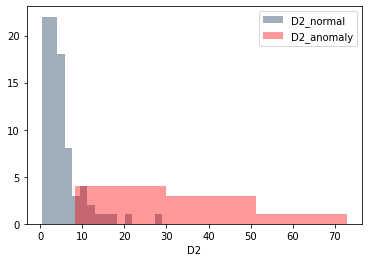

trainデータのT²管理図


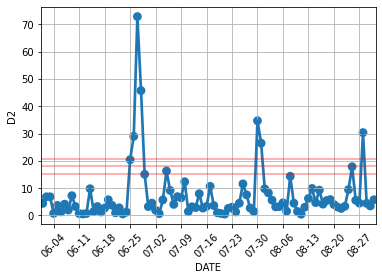

0.1%有意


,D2,DATE
24,28.965073,2020-06-26
1,72.824997,2020-06-27
2,45.719936,2020-06-28
4,34.677071,2020-07-30
5,26.471849,2020-07-31
7,30.325896,2020-08-28


0.3%有意


,D2,DATE
23,20.418982,2020-06-25


1%有意


,D2,DATE
30,16.289772,2020-07-05
78,17.837488,2020-08-25


testデータのT²管理図


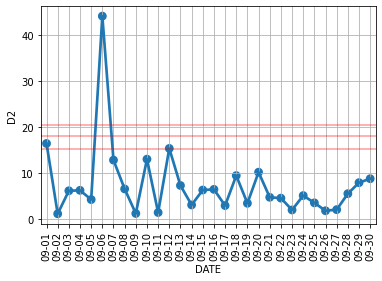

0.1%有意


,D2,DATE
5,44.153487,2020-09-06


0.3%有意


,D2,DATE


1%有意


,D2,DATE
0,16.379116,2020-09-01
11,15.293903,2020-09-12


In [5]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from scipy.stats import chi2
import json
import matplotlib.dates as mdates

#標準化
def scal(x,y):
    scaler = StandardScaler()
    scaler.fit(x.iloc[:,1:-1])
    return scaler.transform(y.iloc[:,1:-1])

#逆行列
def cor(x):
    corr = np.corrcoef(x.T)
    return np.linalg.inv(corr)

def mahara(x,y):
    df_D2 = pd.DataFrame(columns = ['D2'])
    for i in range(len(x)):
        a = np.dot(x[i],y)
        d2 = np.dot(a,x[i].T)
        df_D2 = df_D2.append({'D2':d2},ignore_index=True) 
    return df_D2

#データの取得
name = input('name?')
a = open('../.json/anomaly_day.json')
js = json.load(a)
an_days = js[name]

def unit_space(days):
    #trainデータ
    data_tr = pd.read_csv(f'../../data/{name}_train.csv',encoding = 'utf-8', parse_dates = ['日付'])
    data_tr = data_tr[['日付','項目名','値']]
    df = pd.pivot_table(data_tr,index = '日付',columns = '項目名',values = '値')
    df = df.reset_index()
    df = df.interpolate(axis=0)
    df = df.rename(columns = {'日付':'DATE'})
    df = df.drop(['【朝】体重', '【朝】睡眠時間'], axis=1)
    x_clm = df.columns.unique()

    #異常の日を設定
    df['怪我状態'] = 0
    for i in range(len(days)):
        df.loc[df['DATE'] == days[i] , '怪我状態'] = 1


    #normalデータとanomalyデータを作成
    normal = df[df['怪我状態'] == 0].reset_index(drop = True)
    anomaly = df[df['怪我状態'] == 1].reset_index(drop = True)

    #testデータ
    data_ts = pd.read_csv(f'../../data/{name}_test.csv',encoding = 'utf-8', parse_dates = ['日付'])
    data_ts = data_ts[['日付','項目名','値']]
    test = pd.pivot_table(data_ts,index = '日付',columns = '項目名',values = '値')
    test = test.reset_index()
    test = test.interpolate(axis=0)
    test = test.rename(columns = {'日付':'DATE'})
    test = test.drop(['【朝】体重', '【朝】睡眠時間'], axis=1)
    test['怪我状態'] = 0

    #標準化
    scaled_nm = scal(normal,normal)
    scaled_an = scal(normal,anomaly)

    #逆行列
    corr_inv = cor(scaled_nm)

    #マハラノビス距離
    D2 = mahara(scaled_nm,corr_inv) / (len(x_clm)-1)
    D2['DATE'] = normal['DATE']  #ここから異常値を削除して元に戻りたい

    return D2,test,scaled_nm,scaled_an,corr_inv,normal,anomaly,x_clm

#異常値を単位空間から削除
D2,test,scaled_nm,scaled_an,corr_inv,normal,anomaly,x_clm = unit_space(an_days)
a = D2.loc[D2['D2']>3,'DATE']
an_days.extend(a.dt.strftime("%Y-%m-%d").to_list())

#新しい単位空間を作成
D2,test,scaled_nm,scaled_an,corr_inv,normal,anomaly,x_clm = unit_space(an_days)

#L8直行表
df_l8 = pd.DataFrame([[1,1,1,1,1,1,1],[1,1,1,2,2,2,2],[1,2,2,1,1,2,2],[1,2,2,2,2,1,1],[2,1,2,1,2,1,2],[2,1,2,2,1,2,1],[2,2,1,1,2,2,1],[2,2,1,2,1,1,2]])
l8 = (df_l8==1).values

#各異常値のマハラノビス距離
result = np.zeros(shape=(l8.shape[0], scaled_an.shape[0]))
for x, l8_raw in enumerate(l8):
    for y, an_raw in enumerate(scaled_an):
        select_corr = corr_inv[l8_raw][:,l8_raw]
        select_raw = an_raw[l8_raw]
        result[x, y] = np.dot(np.dot(select_raw.reshape(1,-1), select_corr), select_raw) / sum(l8_raw)

#SN比
sn = np.zeros(l8.shape[0])
for idx, raw in enumerate(result):
    a = 0
    for i in range(len(raw)):
        a += 1/np.square(raw[i])
    sn[idx] = -10 * math.log10(a/len(raw))
display(pd.DataFrame(sn,columns = ['SN比']))

#変数選択
df_sn = pd.DataFrame(index = x_clm[1:],columns = ['SN比','残す'])
for i in range(len(x_clm[1:])):
    df_sn.loc[df_sn.index == x_clm[1+i] , 'SN比'] = sum(sn[l8.T[i]])-sum(sn[l8.T[i] == False])
    df_sn.loc[df_sn.index == x_clm[1+i] , '残す'] = sum(sn[l8.T[i]])-sum(sn[l8.T[i] == False])>0
display(df_sn.reset_index())

#変数削除
normal_d = normal.drop(columns=df_sn[df_sn['残す'] == False].index)
anomaly_d = anomaly.drop(columns=df_sn[df_sn['残す'] == False].index)
test_d = test.drop(columns=df_sn[df_sn['残す'] == False].index)

#標準化
scaled_normal_d = scal(normal_d,normal_d)
scaled_anomaly_d = scal(normal_d,anomaly_d)

#逆行列
corr_inv_d = cor(scaled_normal_d)

# 最終的な単位空間からのマハラノビス距離
D2_normal_d = mahara(scaled_normal_d,corr_inv_d)
D2_normal_d['DATE'] = normal['DATE']

print('anomaly')
D2_anomaly_d = mahara(scaled_anomaly_d,corr_inv_d)
D2_anomaly_d['DATE'] = anomaly['DATE']
display(D2_anomaly_d)

#ヒストグラム
ax1 = sns.distplot(
    D2_normal_d['D2'], label='D2_normal',color='#123456',
    kde=False,
    rug=False)
ax2 = sns.distplot(
    D2_anomaly_d['D2'], label='D2_anomaly',color = 'red',
    kde=False,
    rug=False )
plt.legend() 
plt.show()

#χ2検定の棄却域
kai_0_1 = chi2.ppf(q = 0.999,df = df_sn['残す'].sum())
kai_0_3 = chi2.ppf(q = 0.997,df = df_sn['残す'].sum())
kai_1 = chi2.ppf(q = 0.99,df = df_sn['残す'].sum()) 
kai_5 = chi2.ppf(q = 0.95,df = df_sn['残す'].sum()) 

#trainデータのT²管理図
print('trainデータのT²管理図')
D2_train_df = pd.concat([D2_normal_d,D2_anomaly_d])
D2_train_df = D2_train_df.sort_values(['DATE'])
ax = sns.pointplot(x = 'DATE',y = 'D2',data = D2_train_df)
ax.set_xticklabels(D2_train_df["DATE"].dt.strftime("%m-%d"))
ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=None, interval=7, tz=None))
plt.xticks(rotation = 45)
ax.axhline(y = kai_0_1, linewidth=2, color="red",alpha=0.3)
ax.axhline(y = kai_0_3, linewidth=2, color="red",alpha=0.3)
ax.axhline(y = kai_1, linewidth=2, color="red",alpha=0.3)
# ax.axhline(y = kai_5, linewidth=2, color="red",alpha=0.3)
ax.grid()
plt.show()

#0.1%
print("0.1%有意")
display(D2_train_df[D2_train_df['D2'] > kai_0_1])

#0.3%
print("0.3%有意")
display(D2_train_df[(D2_train_df['D2'] > kai_0_3) & (D2_train_df['D2'] < kai_0_1)])

#1%
print("1%有意")
display(D2_train_df[(D2_train_df['D2'] > kai_1) & (D2_train_df['D2'] < kai_0_3)])

# #5%
# print("5%有意")
# display(D2_train_df[(D2_train_df['D2'] > kai_5) & (D2_train_df['D2'] < kai_1)])


#testデータのT²管理図
scaled_test = scal(normal_d,test_d)
D2_test = mahara(scaled_test,corr_inv_d)
D2_test['DATE'] = test['DATE']
print('testデータのT²管理図')
ax = sns.pointplot(x = 'DATE',y = 'D2',data = D2_test)
ax.set_xticklabels(D2_test["DATE"].dt.strftime("%m-%d"))
ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=None, interval=1, tz=None))
plt.xticks(rotation = 90)
ax.axhline(y = kai_0_1, linewidth=2, color="red",alpha=0.3)
ax.axhline(y = kai_0_3, linewidth=2, color="red",alpha=0.3)
ax.axhline(y = kai_1, linewidth=2, color="red",alpha=0.3)
#ax.axhline(y = kai_5, linewidth=2, color="red",alpha=0.3)
ax.grid()
plt.show()

#0.1%
print("0.1%有意")
display(D2_test[D2_test['D2'] > kai_0_1])

#0.3%
print("0.3%有意")
display(D2_test[(D2_test['D2'] > kai_0_3) & (D2_test['D2'] < kai_0_1)])

#1%
print("1%有意")
display(D2_test[(D2_test['D2'] > kai_1) & (D2_test['D2'] < kai_0_3)])

# #5%
# print("5%有意")
# display(D2_test[(D2_test['D2'] > kai_5) & (D2_test['D2'] < kai_1)])



name? hasebe


,SN比
0,3.900705
1,-6.338922
2,-15.075961
3,9.022370
4,-17.703805
5,2.452768
6,3.135317
7,-6.327195


,項目名,SN比,残す
0,【全員共通】疲労度,9.95111,True
1,【朝】下肢の状態,-8.44379,False
2,【朝】体幹の状態,15.6745,True
3,【朝】疲労度,-24.5528,False
4,【朝】睡眠の質,-3.16464,False
5,【朝】肘の状態,4.71887,True
6,【朝】肩の状態,63.957,True


anomaly


,D2,DATE
0,10.678226,2020-06-09
1,5.109747,2020-06-12
2,10.509342,2020-06-19
3,9.043896,2020-06-21
4,22.642493,2020-07-13
5,12.027739,2020-07-15
6,7.600630,2020-07-26
7,7.963343,2020-08-01
8,5.307745,2020-08-30


C:\Users\baseb\anaconda3\envs\kenkyu\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


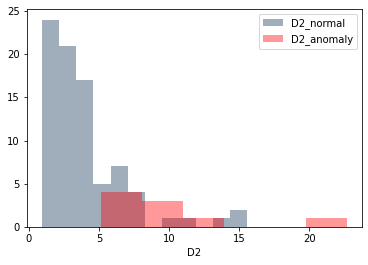

trainデータのT²管理図


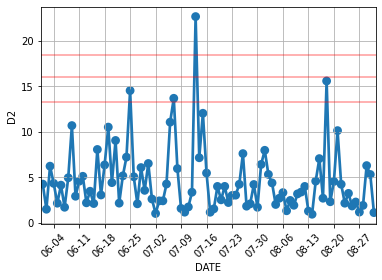

0.1%有意


,D2,DATE
4,22.642493,2020-07-13


0.3%有意


,D2,DATE


1%有意


,D2,DATE
20,14.519675,2020-06-25
32,13.671215,2020-07-07
70,15.572661,2020-08-18


testデータのT²管理図


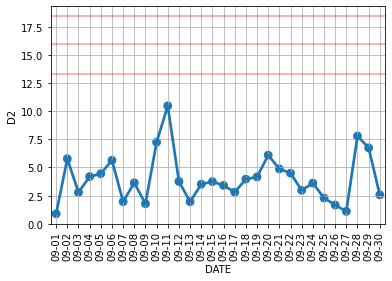

0.1%有意


,D2,DATE


0.3%有意


,D2,DATE


1%有意


,D2,DATE


In [6]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from scipy.stats import chi2
import json
import matplotlib.dates as mdates

#標準化
def scal(x,y):
    scaler = StandardScaler()
    scaler.fit(x.iloc[:,1:-1])
    return scaler.transform(y.iloc[:,1:-1])

#逆行列
def cor(x):
    corr = np.corrcoef(x.T)
    return np.linalg.inv(corr)

def mahara(x,y):
    df_D2 = pd.DataFrame(columns = ['D2'])
    for i in range(len(x)):
        a = np.dot(x[i],y)
        d2 = np.dot(a,x[i].T)
        df_D2 = df_D2.append({'D2':d2},ignore_index=True) 
    return df_D2

#データの取得
name = input('name?')
a = open('../.json/anomaly_day.json')
js = json.load(a)
an_days = js[name]

def unit_space(days):
    #trainデータ
    data_tr = pd.read_csv(f'../../data/{name}_train.csv',encoding = 'utf-8', parse_dates = ['日付'])
    data_tr = data_tr[['日付','項目名','値']]
    df = pd.pivot_table(data_tr,index = '日付',columns = '項目名',values = '値')
    df = df.reset_index()
    df = df.interpolate(axis=0)
    df = df.rename(columns = {'日付':'DATE'})
    df = df.drop(['【朝】体重', '【朝】睡眠時間'], axis=1)
    x_clm = df.columns.unique()

    #異常の日を設定
    df['怪我状態'] = 0
    for i in range(len(days)):
        df.loc[df['DATE'] == days[i] , '怪我状態'] = 1


    #normalデータとanomalyデータを作成
    normal = df[df['怪我状態'] == 0].reset_index(drop = True)
    anomaly = df[df['怪我状態'] == 1].reset_index(drop = True)

    #testデータ
    data_ts = pd.read_csv(f'../../data/{name}_test.csv',encoding = 'utf-8', parse_dates = ['日付'])
    data_ts = data_ts[['日付','項目名','値']]
    test = pd.pivot_table(data_ts,index = '日付',columns = '項目名',values = '値')
    test = test.reset_index()
    test = test.interpolate(axis=0)
    test = test.rename(columns = {'日付':'DATE'})
    test = test.drop(['【朝】体重', '【朝】睡眠時間'], axis=1)
    test['怪我状態'] = 0

    #標準化
    scaled_nm = scal(normal,normal)
    scaled_an = scal(normal,anomaly)

    #逆行列
    corr_inv = cor(scaled_nm)

    #マハラノビス距離
    D2 = mahara(scaled_nm,corr_inv) / (len(x_clm)-1)
    D2['DATE'] = normal['DATE']  #ここから異常値を削除して元に戻りたい

    return D2,test,scaled_nm,scaled_an,corr_inv,normal,anomaly,x_clm

#異常値を単位空間から削除
D2,test,scaled_nm,scaled_an,corr_inv,normal,anomaly,x_clm = unit_space(an_days)
a = D2.loc[D2['D2']>3,'DATE']
an_days.extend(a.dt.strftime("%Y-%m-%d").to_list())

#新しい単位空間を作成
D2,test,scaled_nm,scaled_an,corr_inv,normal,anomaly,x_clm = unit_space(an_days)

#L8直行表
df_l8 = pd.DataFrame([[1,1,1,1,1,1,1],[1,1,1,2,2,2,2],[1,2,2,1,1,2,2],[1,2,2,2,2,1,1],[2,1,2,1,2,1,2],[2,1,2,2,1,2,1],[2,2,1,1,2,2,1],[2,2,1,2,1,1,2]])
l8 = (df_l8==1).values

#各異常値のマハラノビス距離
result = np.zeros(shape=(l8.shape[0], scaled_an.shape[0]))
for x, l8_raw in enumerate(l8):
    for y, an_raw in enumerate(scaled_an):
        select_corr = corr_inv[l8_raw][:,l8_raw]
        select_raw = an_raw[l8_raw]
        result[x, y] = np.dot(np.dot(select_raw.reshape(1,-1), select_corr), select_raw) / sum(l8_raw)

#SN比
sn = np.zeros(l8.shape[0])
for idx, raw in enumerate(result):
    a = 0
    for i in range(len(raw)):
        a += 1/np.square(raw[i])
    sn[idx] = -10 * math.log10(a/len(raw))
display(pd.DataFrame(sn,columns = ['SN比']))

#変数選択
df_sn = pd.DataFrame(index = x_clm[1:],columns = ['SN比','残す'])
for i in range(len(x_clm[1:])):
    df_sn.loc[df_sn.index == x_clm[1+i] , 'SN比'] = sum(sn[l8.T[i]])-sum(sn[l8.T[i] == False])
    df_sn.loc[df_sn.index == x_clm[1+i] , '残す'] = sum(sn[l8.T[i]])-sum(sn[l8.T[i] == False])>0
display(df_sn.reset_index())

#変数削除
normal_d = normal.drop(columns=df_sn[df_sn['残す'] == False].index)
anomaly_d = anomaly.drop(columns=df_sn[df_sn['残す'] == False].index)
test_d = test.drop(columns=df_sn[df_sn['残す'] == False].index)

#標準化
scaled_normal_d = scal(normal_d,normal_d)
scaled_anomaly_d = scal(normal_d,anomaly_d)

#逆行列
corr_inv_d = cor(scaled_normal_d)

# 最終的な単位空間からのマハラノビス距離
D2_normal_d = mahara(scaled_normal_d,corr_inv_d)
D2_normal_d['DATE'] = normal['DATE']

print('anomaly')
D2_anomaly_d = mahara(scaled_anomaly_d,corr_inv_d)
D2_anomaly_d['DATE'] = anomaly['DATE']
display(D2_anomaly_d)

#ヒストグラム
ax1 = sns.distplot(
    D2_normal_d['D2'], label='D2_normal',color='#123456',
    kde=False,
    rug=False)
ax2 = sns.distplot(
    D2_anomaly_d['D2'], label='D2_anomaly',color = 'red',
    kde=False,
    rug=False )
plt.legend() 
plt.show()

#χ2検定の棄却域
kai_0_1 = chi2.ppf(q = 0.999,df = df_sn['残す'].sum())
kai_0_3 = chi2.ppf(q = 0.997,df = df_sn['残す'].sum())
kai_1 = chi2.ppf(q = 0.99,df = df_sn['残す'].sum()) 
kai_5 = chi2.ppf(q = 0.95,df = df_sn['残す'].sum()) 

#trainデータのT²管理図
print('trainデータのT²管理図')
D2_train_df = pd.concat([D2_normal_d,D2_anomaly_d])
D2_train_df = D2_train_df.sort_values(['DATE'])
ax = sns.pointplot(x = 'DATE',y = 'D2',data = D2_train_df)
ax.set_xticklabels(D2_train_df["DATE"].dt.strftime("%m-%d"))
ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=None, interval=7, tz=None))
plt.xticks(rotation = 45)
ax.axhline(y = kai_0_1, linewidth=2, color="red",alpha=0.3)
ax.axhline(y = kai_0_3, linewidth=2, color="red",alpha=0.3)
ax.axhline(y = kai_1, linewidth=2, color="red",alpha=0.3)
# ax.axhline(y = kai_5, linewidth=2, color="red",alpha=0.3)
ax.grid()
plt.show()

#0.1%
print("0.1%有意")
display(D2_train_df[D2_train_df['D2'] > kai_0_1])

#0.3%
print("0.3%有意")
display(D2_train_df[(D2_train_df['D2'] > kai_0_3) & (D2_train_df['D2'] < kai_0_1)])

#1%
print("1%有意")
display(D2_train_df[(D2_train_df['D2'] > kai_1) & (D2_train_df['D2'] < kai_0_3)])

# #5%
# print("5%有意")
# display(D2_train_df[(D2_train_df['D2'] > kai_5) & (D2_train_df['D2'] < kai_1)])


#testデータのT²管理図
scaled_test = scal(normal_d,test_d)
D2_test = mahara(scaled_test,corr_inv_d)
D2_test['DATE'] = test['DATE']
print('testデータのT²管理図')
ax = sns.pointplot(x = 'DATE',y = 'D2',data = D2_test)
ax.set_xticklabels(D2_test["DATE"].dt.strftime("%m-%d"))
ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=None, interval=1, tz=None))
plt.xticks(rotation = 90)
ax.axhline(y = kai_0_1, linewidth=2, color="red",alpha=0.3)
ax.axhline(y = kai_0_3, linewidth=2, color="red",alpha=0.3)
ax.axhline(y = kai_1, linewidth=2, color="red",alpha=0.3)
#ax.axhline(y = kai_5, linewidth=2, color="red",alpha=0.3)
ax.grid()
plt.show()

#0.1%
print("0.1%有意")
display(D2_test[D2_test['D2'] > kai_0_1])

#0.3%
print("0.3%有意")
display(D2_test[(D2_test['D2'] > kai_0_3) & (D2_test['D2'] < kai_0_1)])

#1%
print("1%有意")
display(D2_test[(D2_test['D2'] > kai_1) & (D2_test['D2'] < kai_0_3)])

# #5%
# print("5%有意")
# display(D2_test[(D2_test['D2'] > kai_5) & (D2_test['D2'] < kai_1)])



name? morita


,SN比
0,7.100210
1,3.260814
2,-2.411655
3,13.497304
4,8.871388
5,18.381034
6,16.949557
7,8.985910


,項目名,SN比,残す
0,【全員共通】疲労度,-31.7412,False
1,【朝】下肢の状態,0.592331,True
2,【朝】体幹の状態,-2.04158,False
3,【朝】疲労度,-13.6156,False
4,【朝】睡眠の質,-10.5236,False
5,【朝】肘の状態,2.27506,True
6,【朝】肩の状態,37.2216,True


anomaly


,D2,DATE
0,29.639308,2020-08-13
1,9.210188,2020-08-14
2,64.312780,2020-08-25
3,8.171373,2020-09-14
4,20.882824,2020-10-08
5,6.309203,2020-10-11
6,7.096261,2020-10-12
7,9.251246,2020-10-15


C:\Users\baseb\anaconda3\envs\kenkyu\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


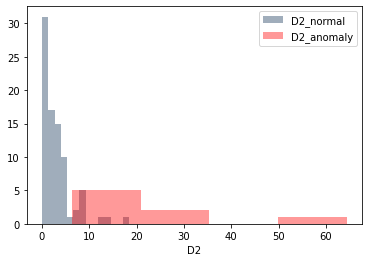

trainデータのT²管理図


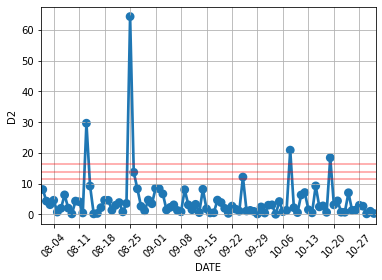

0.1%有意


,D2,DATE
0,29.639308,2020-08-13
2,64.312780,2020-08-25
4,20.882824,2020-10-08
71,18.416006,2020-10-19


0.3%有意


,D2,DATE


1%有意


,D2,DATE
22,13.684511,2020-08-26
51,12.133731,2020-09-25


testデータのT²管理図


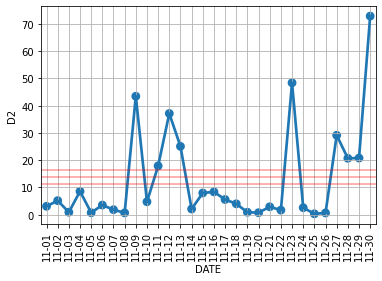

0.1%有意


,D2,DATE
8,43.431415,2020-11-09
10,17.867372,2020-11-11
11,37.101284,2020-11-12
12,25.044030,2020-11-13
22,48.372861,2020-11-23
26,29.109101,2020-11-27
27,20.647819,2020-11-28
28,20.744037,2020-11-29
29,72.854694,2020-11-30


0.3%有意


,D2,DATE


1%有意


,D2,DATE


In [10]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from scipy.stats import chi2
import json
import matplotlib.dates as mdates

#標準化
def scal(x,y):
    scaler = StandardScaler()
    scaler.fit(x.iloc[:,1:-1])
    return scaler.transform(y.iloc[:,1:-1])

#逆行列
def cor(x):
    corr = np.corrcoef(x.T)
    return np.linalg.inv(corr)

def mahara(x,y):
    df_D2 = pd.DataFrame(columns = ['D2'])
    for i in range(len(x)):
        a = np.dot(x[i],y)
        d2 = np.dot(a,x[i].T)
        df_D2 = df_D2.append({'D2':d2},ignore_index=True) 
    return df_D2

#データの取得
name = input('name?')
a = open('../.json/anomaly_day.json')
js = json.load(a)
an_days = js[name]

def unit_space(days):
    #trainデータ
    data_tr = pd.read_csv(f'../../data/{name}_train.csv',encoding = 'utf-8', parse_dates = ['日付'])
    data_tr = data_tr[['日付','項目名','値']]
    df = pd.pivot_table(data_tr,index = '日付',columns = '項目名',values = '値')
    df = df.reset_index()
    df = df.interpolate(axis=0)
    df = df.rename(columns = {'日付':'DATE'})
    df = df.drop(['【朝】体重', '【朝】睡眠時間'], axis=1)
    x_clm = df.columns.unique()

    #異常の日を設定
    df['怪我状態'] = 0
    for i in range(len(days)):
        df.loc[df['DATE'] == days[i] , '怪我状態'] = 1


    #normalデータとanomalyデータを作成
    normal = df[df['怪我状態'] == 0].reset_index(drop = True)
    anomaly = df[df['怪我状態'] == 1].reset_index(drop = True)

    #testデータ
    data_ts = pd.read_csv(f'../../data/{name}_test.csv',encoding = 'utf-8', parse_dates = ['日付'])
    data_ts = data_ts[['日付','項目名','値']]
    test = pd.pivot_table(data_ts,index = '日付',columns = '項目名',values = '値')
    test = test.reset_index()
    test = test.interpolate(axis=0)
    test = test.rename(columns = {'日付':'DATE'})
    test = test.drop(['【朝】体重', '【朝】睡眠時間'], axis=1)
    test['怪我状態'] = 0

    #標準化
    scaled_nm = scal(normal,normal)
    scaled_an = scal(normal,anomaly)

    #逆行列
    corr_inv = cor(scaled_nm)

    #マハラノビス距離
    D2 = mahara(scaled_nm,corr_inv) / (len(x_clm)-1)
    D2['DATE'] = normal['DATE']  #ここから異常値を削除して元に戻りたい

    return D2,test,scaled_nm,scaled_an,corr_inv,normal,anomaly,x_clm

#異常値を単位空間から削除
D2,test,scaled_nm,scaled_an,corr_inv,normal,anomaly,x_clm = unit_space(an_days)
a = D2.loc[D2['D2']>3,'DATE']
an_days.extend(a.dt.strftime("%Y-%m-%d").to_list())

#新しい単位空間を作成
D2,test,scaled_nm,scaled_an,corr_inv,normal,anomaly,x_clm = unit_space(an_days)

#L8直行表
df_l8 = pd.DataFrame([[1,1,1,1,1,1,1],[1,1,1,2,2,2,2],[1,2,2,1,1,2,2],[1,2,2,2,2,1,1],[2,1,2,1,2,1,2],[2,1,2,2,1,2,1],[2,2,1,1,2,2,1],[2,2,1,2,1,1,2]])
l8 = (df_l8==1).values

#各異常値のマハラノビス距離
result = np.zeros(shape=(l8.shape[0], scaled_an.shape[0]))
for x, l8_raw in enumerate(l8):
    for y, an_raw in enumerate(scaled_an):
        select_corr = corr_inv[l8_raw][:,l8_raw]
        select_raw = an_raw[l8_raw]
        result[x, y] = np.dot(np.dot(select_raw.reshape(1,-1), select_corr), select_raw) / sum(l8_raw)

#SN比
sn = np.zeros(l8.shape[0])
for idx, raw in enumerate(result):
    a = 0
    for i in range(len(raw)):
        a += 1/np.square(raw[i])
    sn[idx] = -10 * math.log10(a/len(raw))
display(pd.DataFrame(sn,columns = ['SN比']))

#変数選択
df_sn = pd.DataFrame(index = x_clm[1:],columns = ['SN比','残す'])
for i in range(len(x_clm[1:])):
    df_sn.loc[df_sn.index == x_clm[1+i] , 'SN比'] = sum(sn[l8.T[i]])-sum(sn[l8.T[i] == False])
    df_sn.loc[df_sn.index == x_clm[1+i] , '残す'] = sum(sn[l8.T[i]])-sum(sn[l8.T[i] == False])>0
display(df_sn.reset_index())

#変数削除
normal_d = normal.drop(columns=df_sn[df_sn['残す'] == False].index)
anomaly_d = anomaly.drop(columns=df_sn[df_sn['残す'] == False].index)
test_d = test.drop(columns=df_sn[df_sn['残す'] == False].index)

#標準化
scaled_normal_d = scal(normal_d,normal_d)
scaled_anomaly_d = scal(normal_d,anomaly_d)

#逆行列
corr_inv_d = cor(scaled_normal_d)

# 最終的な単位空間からのマハラノビス距離
D2_normal_d = mahara(scaled_normal_d,corr_inv_d)
D2_normal_d['DATE'] = normal['DATE']

print('anomaly')
D2_anomaly_d = mahara(scaled_anomaly_d,corr_inv_d)
D2_anomaly_d['DATE'] = anomaly['DATE']
display(D2_anomaly_d)

#ヒストグラム
ax1 = sns.distplot(
    D2_normal_d['D2'], label='D2_normal',color='#123456',
    kde=False,
    rug=False)
ax2 = sns.distplot(
    D2_anomaly_d['D2'], label='D2_anomaly',color = 'red',
    kde=False,
    rug=False )
plt.legend() 
plt.show()

#χ2検定の棄却域
kai_0_1 = chi2.ppf(q = 0.999,df = df_sn['残す'].sum())
kai_0_3 = chi2.ppf(q = 0.997,df = df_sn['残す'].sum())
kai_1 = chi2.ppf(q = 0.99,df = df_sn['残す'].sum()) 
kai_5 = chi2.ppf(q = 0.95,df = df_sn['残す'].sum()) 

#trainデータのT²管理図
print('trainデータのT²管理図')
D2_train_df = pd.concat([D2_normal_d,D2_anomaly_d])
D2_train_df = D2_train_df.sort_values(['DATE'])
ax = sns.pointplot(x = 'DATE',y = 'D2',data = D2_train_df)
ax.set_xticklabels(D2_train_df["DATE"].dt.strftime("%m-%d"))
ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=None, interval=7, tz=None))
plt.xticks(rotation = 45)
ax.axhline(y = kai_0_1, linewidth=2, color="red",alpha=0.3)
ax.axhline(y = kai_0_3, linewidth=2, color="red",alpha=0.3)
ax.axhline(y = kai_1, linewidth=2, color="red",alpha=0.3)
# ax.axhline(y = kai_5, linewidth=2, color="red",alpha=0.3)
ax.grid()
plt.show()

#0.1%
print("0.1%有意")
display(D2_train_df[D2_train_df['D2'] > kai_0_1])

#0.3%
print("0.3%有意")
display(D2_train_df[(D2_train_df['D2'] > kai_0_3) & (D2_train_df['D2'] < kai_0_1)])

#1%
print("1%有意")
display(D2_train_df[(D2_train_df['D2'] > kai_1) & (D2_train_df['D2'] < kai_0_3)])

# #5%
# print("5%有意")
# display(D2_train_df[(D2_train_df['D2'] > kai_5) & (D2_train_df['D2'] < kai_1)])


#testデータのT²管理図
scaled_test = scal(normal_d,test_d)
D2_test = mahara(scaled_test,corr_inv_d)
D2_test['DATE'] = test['DATE']
print('testデータのT²管理図')
ax = sns.pointplot(x = 'DATE',y = 'D2',data = D2_test)
ax.set_xticklabels(D2_test["DATE"].dt.strftime("%m-%d"))
ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=None, interval=1, tz=None))
plt.xticks(rotation = 90)
ax.axhline(y = kai_0_1, linewidth=2, color="red",alpha=0.3)
ax.axhline(y = kai_0_3, linewidth=2, color="red",alpha=0.3)
ax.axhline(y = kai_1, linewidth=2, color="red",alpha=0.3)
#ax.axhline(y = kai_5, linewidth=2, color="red",alpha=0.3)
ax.grid()
plt.show()

#0.1%
print("0.1%有意")
display(D2_test[D2_test['D2'] > kai_0_1])

#0.3%
print("0.3%有意")
display(D2_test[(D2_test['D2'] > kai_0_3) & (D2_test['D2'] < kai_0_1)])

#1%
print("1%有意")
display(D2_test[(D2_test['D2'] > kai_1) & (D2_test['D2'] < kai_0_3)])

# #5%
# print("5%有意")
# display(D2_test[(D2_test['D2'] > kai_5) & (D2_test['D2'] < kai_1)])



name? marutani


,SN比
0,7.604234
1,-13.731229
2,-17.599120
3,-4.344104
4,3.955090
5,1.324713
6,3.826796
7,7.829364


,項目名,SN比,残す
0,【全員共通】疲労度,-45.0062,False
1,【朝】下肢の状態,9.43987,True
2,【朝】体幹の状態,22.1926,True
3,【朝】疲労度,6.70826,True
4,【朝】睡眠の質,9.45264,True
5,【朝】肘の状態,41.2234,True
6,【朝】肩の状態,27.9575,True


anomaly


,D2,DATE
0,21.796512,2020-08-08
1,8.649335,2020-08-17
2,16.701327,2020-08-19
3,14.441267,2020-08-20
4,28.322400,2020-08-24
5,17.897408,2020-09-04
6,32.813366,2020-10-08


C:\Users\baseb\anaconda3\envs\kenkyu\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


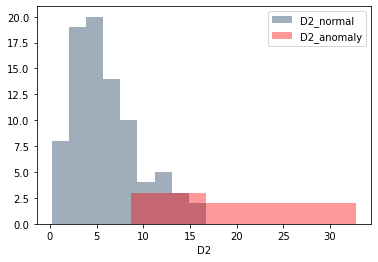

trainデータのT²管理図


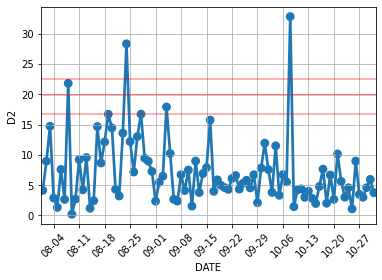

0.1%有意


,D2,DATE
4,28.322400,2020-08-24
6,32.813366,2020-10-08


0.3%有意


,D2,DATE
0,21.796512,2020-08-08


1%有意


,D2,DATE
5,17.897408,2020-09-04


testデータのT²管理図


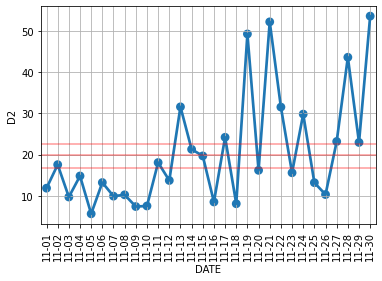

0.1%有意


,D2,DATE
12,31.573353,2020-11-13
16,24.180750,2020-11-17
18,49.270108,2020-11-19
20,52.209375,2020-11-21
21,31.518690,2020-11-22
23,29.808632,2020-11-24
26,23.158164,2020-11-27
27,43.610904,2020-11-28
28,22.931897,2020-11-29
29,53.602901,2020-11-30


0.3%有意


,D2,DATE
13,21.264501,2020-11-14


1%有意


,D2,DATE
1,17.534967,2020-11-02
10,18.046384,2020-11-11
14,19.657422,2020-11-15


In [11]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from scipy.stats import chi2
import json
import matplotlib.dates as mdates

#標準化
def scal(x,y):
    scaler = StandardScaler()
    scaler.fit(x.iloc[:,1:-1])
    return scaler.transform(y.iloc[:,1:-1])

#逆行列
def cor(x):
    corr = np.corrcoef(x.T)
    return np.linalg.inv(corr)

def mahara(x,y):
    df_D2 = pd.DataFrame(columns = ['D2'])
    for i in range(len(x)):
        a = np.dot(x[i],y)
        d2 = np.dot(a,x[i].T)
        df_D2 = df_D2.append({'D2':d2},ignore_index=True) 
    return df_D2

#データの取得
name = input('name?')
a = open('../.json/anomaly_day.json')
js = json.load(a)
an_days = js[name]

def unit_space(days):
    #trainデータ
    data_tr = pd.read_csv(f'../../data/{name}_train.csv',encoding = 'utf-8', parse_dates = ['日付'])
    data_tr = data_tr[['日付','項目名','値']]
    df = pd.pivot_table(data_tr,index = '日付',columns = '項目名',values = '値')
    df = df.reset_index()
    df = df.interpolate(axis=0)
    df = df.rename(columns = {'日付':'DATE'})
    df = df.drop(['【朝】体重', '【朝】睡眠時間'], axis=1)
    x_clm = df.columns.unique()

    #異常の日を設定
    df['怪我状態'] = 0
    for i in range(len(days)):
        df.loc[df['DATE'] == days[i] , '怪我状態'] = 1


    #normalデータとanomalyデータを作成
    normal = df[df['怪我状態'] == 0].reset_index(drop = True)
    anomaly = df[df['怪我状態'] == 1].reset_index(drop = True)

    #testデータ
    data_ts = pd.read_csv(f'../../data/{name}_test.csv',encoding = 'utf-8', parse_dates = ['日付'])
    data_ts = data_ts[['日付','項目名','値']]
    test = pd.pivot_table(data_ts,index = '日付',columns = '項目名',values = '値')
    test = test.reset_index()
    test = test.interpolate(axis=0)
    test = test.rename(columns = {'日付':'DATE'})
    test = test.drop(['【朝】体重', '【朝】睡眠時間'], axis=1)
    test['怪我状態'] = 0

    #標準化
    scaled_nm = scal(normal,normal)
    scaled_an = scal(normal,anomaly)

    #逆行列
    corr_inv = cor(scaled_nm)

    #マハラノビス距離
    D2 = mahara(scaled_nm,corr_inv) / (len(x_clm)-1)
    D2['DATE'] = normal['DATE']  #ここから異常値を削除して元に戻りたい

    return D2,test,scaled_nm,scaled_an,corr_inv,normal,anomaly,x_clm

#異常値を単位空間から削除
D2,test,scaled_nm,scaled_an,corr_inv,normal,anomaly,x_clm = unit_space(an_days)
a = D2.loc[D2['D2']>3,'DATE']
an_days.extend(a.dt.strftime("%Y-%m-%d").to_list())

#新しい単位空間を作成
D2,test,scaled_nm,scaled_an,corr_inv,normal,anomaly,x_clm = unit_space(an_days)

#L8直行表
df_l8 = pd.DataFrame([[1,1,1,1,1,1,1],[1,1,1,2,2,2,2],[1,2,2,1,1,2,2],[1,2,2,2,2,1,1],[2,1,2,1,2,1,2],[2,1,2,2,1,2,1],[2,2,1,1,2,2,1],[2,2,1,2,1,1,2]])
l8 = (df_l8==1).values

#各異常値のマハラノビス距離
result = np.zeros(shape=(l8.shape[0], scaled_an.shape[0]))
for x, l8_raw in enumerate(l8):
    for y, an_raw in enumerate(scaled_an):
        select_corr = corr_inv[l8_raw][:,l8_raw]
        select_raw = an_raw[l8_raw]
        result[x, y] = np.dot(np.dot(select_raw.reshape(1,-1), select_corr), select_raw) / sum(l8_raw)

#SN比
sn = np.zeros(l8.shape[0])
for idx, raw in enumerate(result):
    a = 0
    for i in range(len(raw)):
        a += 1/np.square(raw[i])
    sn[idx] = -10 * math.log10(a/len(raw))
display(pd.DataFrame(sn,columns = ['SN比']))

#変数選択
df_sn = pd.DataFrame(index = x_clm[1:],columns = ['SN比','残す'])
for i in range(len(x_clm[1:])):
    df_sn.loc[df_sn.index == x_clm[1+i] , 'SN比'] = sum(sn[l8.T[i]])-sum(sn[l8.T[i] == False])
    df_sn.loc[df_sn.index == x_clm[1+i] , '残す'] = sum(sn[l8.T[i]])-sum(sn[l8.T[i] == False])>0
display(df_sn.reset_index())

#変数削除
normal_d = normal.drop(columns=df_sn[df_sn['残す'] == False].index)
anomaly_d = anomaly.drop(columns=df_sn[df_sn['残す'] == False].index)
test_d = test.drop(columns=df_sn[df_sn['残す'] == False].index)

#標準化
scaled_normal_d = scal(normal_d,normal_d)
scaled_anomaly_d = scal(normal_d,anomaly_d)

#逆行列
corr_inv_d = cor(scaled_normal_d)

# 最終的な単位空間からのマハラノビス距離
D2_normal_d = mahara(scaled_normal_d,corr_inv_d)
D2_normal_d['DATE'] = normal['DATE']

print('anomaly')
D2_anomaly_d = mahara(scaled_anomaly_d,corr_inv_d)
D2_anomaly_d['DATE'] = anomaly['DATE']
display(D2_anomaly_d)

#ヒストグラム
ax1 = sns.distplot(
    D2_normal_d['D2'], label='D2_normal',color='#123456',
    kde=False,
    rug=False)
ax2 = sns.distplot(
    D2_anomaly_d['D2'], label='D2_anomaly',color = 'red',
    kde=False,
    rug=False )
plt.legend() 
plt.show()

#χ2検定の棄却域
kai_0_1 = chi2.ppf(q = 0.999,df = df_sn['残す'].sum())
kai_0_3 = chi2.ppf(q = 0.997,df = df_sn['残す'].sum())
kai_1 = chi2.ppf(q = 0.99,df = df_sn['残す'].sum()) 
kai_5 = chi2.ppf(q = 0.95,df = df_sn['残す'].sum()) 

#trainデータのT²管理図
print('trainデータのT²管理図')
D2_train_df = pd.concat([D2_normal_d,D2_anomaly_d])
D2_train_df = D2_train_df.sort_values(['DATE'])
ax = sns.pointplot(x = 'DATE',y = 'D2',data = D2_train_df)
ax.set_xticklabels(D2_train_df["DATE"].dt.strftime("%m-%d"))
ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=None, interval=7, tz=None))
plt.xticks(rotation = 45)
ax.axhline(y = kai_0_1, linewidth=2, color="red",alpha=0.3)
ax.axhline(y = kai_0_3, linewidth=2, color="red",alpha=0.3)
ax.axhline(y = kai_1, linewidth=2, color="red",alpha=0.3)
# ax.axhline(y = kai_5, linewidth=2, color="red",alpha=0.3)
ax.grid()
plt.show()

#0.1%
print("0.1%有意")
display(D2_train_df[D2_train_df['D2'] > kai_0_1])

#0.3%
print("0.3%有意")
display(D2_train_df[(D2_train_df['D2'] > kai_0_3) & (D2_train_df['D2'] < kai_0_1)])

#1%
print("1%有意")
display(D2_train_df[(D2_train_df['D2'] > kai_1) & (D2_train_df['D2'] < kai_0_3)])

# #5%
# print("5%有意")
# display(D2_train_df[(D2_train_df['D2'] > kai_5) & (D2_train_df['D2'] < kai_1)])


#testデータのT²管理図
scaled_test = scal(normal_d,test_d)
D2_test = mahara(scaled_test,corr_inv_d)
D2_test['DATE'] = test['DATE']
print('testデータのT²管理図')
ax = sns.pointplot(x = 'DATE',y = 'D2',data = D2_test)
ax.set_xticklabels(D2_test["DATE"].dt.strftime("%m-%d"))
ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=None, interval=1, tz=None))
plt.xticks(rotation = 90)
ax.axhline(y = kai_0_1, linewidth=2, color="red",alpha=0.3)
ax.axhline(y = kai_0_3, linewidth=2, color="red",alpha=0.3)
ax.axhline(y = kai_1, linewidth=2, color="red",alpha=0.3)
#ax.axhline(y = kai_5, linewidth=2, color="red",alpha=0.3)
ax.grid()
plt.show()

#0.1%
print("0.1%有意")
display(D2_test[D2_test['D2'] > kai_0_1])

#0.3%
print("0.3%有意")
display(D2_test[(D2_test['D2'] > kai_0_3) & (D2_test['D2'] < kai_0_1)])

#1%
print("1%有意")
display(D2_test[(D2_test['D2'] > kai_1) & (D2_test['D2'] < kai_0_3)])

# #5%
# print("5%有意")
# display(D2_test[(D2_test['D2'] > kai_5) & (D2_test['D2'] < kai_1)])



name? namai


,SN比
0,12.991147
1,-29.175750
2,0.471746
3,15.550230
4,15.832474
5,11.952174
6,5.746875
7,13.176763


,項目名,SN比,残す
0,【全員共通】疲労度,-46.8709,False
1,【朝】下肢の状態,-23.3456,False
2,【朝】体幹の状態,-41.0676,False
3,【朝】疲労度,23.5388,True
4,【朝】睡眠の質,30.638,True
5,【朝】肘の状態,68.5556,True
6,【朝】肩の状態,45.9352,True


anomaly


,D2,DATE
0,36.611433,2020-08-02
1,19.553132,2020-08-05
2,19.751203,2020-08-17
3,33.120151,2020-08-28
4,23.741725,2020-09-04
5,41.620349,2020-09-13
6,42.159365,2020-09-15
7,24.389538,2020-09-28
8,22.150804,2020-10-05
9,58.893920,2020-10-13


C:\Users\baseb\anaconda3\envs\kenkyu\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


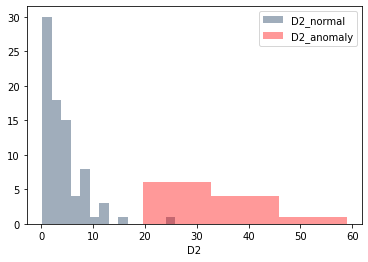

trainデータのT²管理図


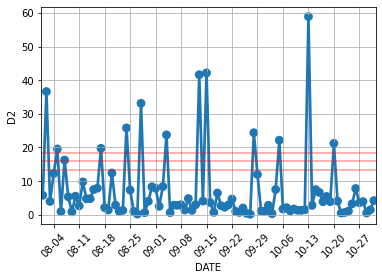

0.1%有意


,D2,DATE
0,36.611433,2020-08-02
1,19.553132,2020-08-05
2,19.751203,2020-08-17
20,25.803805,2020-08-24
3,33.120151,2020-08-28
4,23.741725,2020-09-04
5,41.620349,2020-09-13
6,42.159365,2020-09-15
7,24.389538,2020-09-28
8,22.150804,2020-10-05


0.3%有意


,D2,DATE
4,16.254636,2020-08-07


1%有意


,D2,DATE


testデータのT²管理図


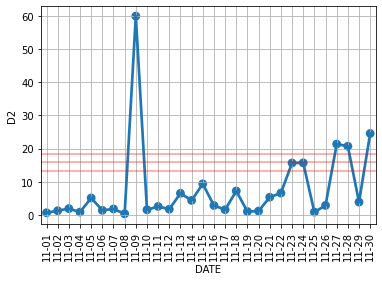

0.1%有意


,D2,DATE
8,60.043173,2020-11-09
26,21.352030,2020-11-27
27,20.701094,2020-11-28
29,24.553790,2020-11-30


0.3%有意


,D2,DATE


1%有意


,D2,DATE
22,15.628837,2020-11-23
23,15.674521,2020-11-24


In [12]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from scipy.stats import chi2
import json
import matplotlib.dates as mdates

#標準化
def scal(x,y):
    scaler = StandardScaler()
    scaler.fit(x.iloc[:,1:-1])
    return scaler.transform(y.iloc[:,1:-1])

#逆行列
def cor(x):
    corr = np.corrcoef(x.T)
    return np.linalg.inv(corr)

def mahara(x,y):
    df_D2 = pd.DataFrame(columns = ['D2'])
    for i in range(len(x)):
        a = np.dot(x[i],y)
        d2 = np.dot(a,x[i].T)
        df_D2 = df_D2.append({'D2':d2},ignore_index=True) 
    return df_D2

#データの取得
name = input('name?')
a = open('../.json/anomaly_day.json')
js = json.load(a)
an_days = js[name]

def unit_space(days):
    #trainデータ
    data_tr = pd.read_csv(f'../../data/{name}_train.csv',encoding = 'utf-8', parse_dates = ['日付'])
    data_tr = data_tr[['日付','項目名','値']]
    df = pd.pivot_table(data_tr,index = '日付',columns = '項目名',values = '値')
    df = df.reset_index()
    df = df.interpolate(axis=0)
    df = df.rename(columns = {'日付':'DATE'})
    df = df.drop(['【朝】体重', '【朝】睡眠時間'], axis=1)
    x_clm = df.columns.unique()

    #異常の日を設定
    df['怪我状態'] = 0
    for i in range(len(days)):
        df.loc[df['DATE'] == days[i] , '怪我状態'] = 1


    #normalデータとanomalyデータを作成
    normal = df[df['怪我状態'] == 0].reset_index(drop = True)
    anomaly = df[df['怪我状態'] == 1].reset_index(drop = True)

    #testデータ
    data_ts = pd.read_csv(f'../../data/{name}_test.csv',encoding = 'utf-8', parse_dates = ['日付'])
    data_ts = data_ts[['日付','項目名','値']]
    test = pd.pivot_table(data_ts,index = '日付',columns = '項目名',values = '値')
    test = test.reset_index()
    test = test.interpolate(axis=0)
    test = test.rename(columns = {'日付':'DATE'})
    test = test.drop(['【朝】体重', '【朝】睡眠時間'], axis=1)
    test['怪我状態'] = 0

    #標準化
    scaled_nm = scal(normal,normal)
    scaled_an = scal(normal,anomaly)

    #逆行列
    corr_inv = cor(scaled_nm)

    #マハラノビス距離
    D2 = mahara(scaled_nm,corr_inv) / (len(x_clm)-1)
    D2['DATE'] = normal['DATE']  #ここから異常値を削除して元に戻りたい

    return D2,test,scaled_nm,scaled_an,corr_inv,normal,anomaly,x_clm

#異常値を単位空間から削除
D2,test,scaled_nm,scaled_an,corr_inv,normal,anomaly,x_clm = unit_space(an_days)
a = D2.loc[D2['D2']>3,'DATE']
an_days.extend(a.dt.strftime("%Y-%m-%d").to_list())

#新しい単位空間を作成
D2,test,scaled_nm,scaled_an,corr_inv,normal,anomaly,x_clm = unit_space(an_days)

#L8直行表
df_l8 = pd.DataFrame([[1,1,1,1,1,1,1],[1,1,1,2,2,2,2],[1,2,2,1,1,2,2],[1,2,2,2,2,1,1],[2,1,2,1,2,1,2],[2,1,2,2,1,2,1],[2,2,1,1,2,2,1],[2,2,1,2,1,1,2]])
l8 = (df_l8==1).values

#各異常値のマハラノビス距離
result = np.zeros(shape=(l8.shape[0], scaled_an.shape[0]))
for x, l8_raw in enumerate(l8):
    for y, an_raw in enumerate(scaled_an):
        select_corr = corr_inv[l8_raw][:,l8_raw]
        select_raw = an_raw[l8_raw]
        result[x, y] = np.dot(np.dot(select_raw.reshape(1,-1), select_corr), select_raw) / sum(l8_raw)

#SN比
sn = np.zeros(l8.shape[0])
for idx, raw in enumerate(result):
    a = 0
    for i in range(len(raw)):
        a += 1/np.square(raw[i])
    sn[idx] = -10 * math.log10(a/len(raw))
display(pd.DataFrame(sn,columns = ['SN比']))

#変数選択
df_sn = pd.DataFrame(index = x_clm[1:],columns = ['SN比','残す'])
for i in range(len(x_clm[1:])):
    df_sn.loc[df_sn.index == x_clm[1+i] , 'SN比'] = sum(sn[l8.T[i]])-sum(sn[l8.T[i] == False])
    df_sn.loc[df_sn.index == x_clm[1+i] , '残す'] = sum(sn[l8.T[i]])-sum(sn[l8.T[i] == False])>0
display(df_sn.reset_index())

#変数削除
normal_d = normal.drop(columns=df_sn[df_sn['残す'] == False].index)
anomaly_d = anomaly.drop(columns=df_sn[df_sn['残す'] == False].index)
test_d = test.drop(columns=df_sn[df_sn['残す'] == False].index)

#標準化
scaled_normal_d = scal(normal_d,normal_d)
scaled_anomaly_d = scal(normal_d,anomaly_d)

#逆行列
corr_inv_d = cor(scaled_normal_d)

# 最終的な単位空間からのマハラノビス距離
D2_normal_d = mahara(scaled_normal_d,corr_inv_d)
D2_normal_d['DATE'] = normal['DATE']

print('anomaly')
D2_anomaly_d = mahara(scaled_anomaly_d,corr_inv_d)
D2_anomaly_d['DATE'] = anomaly['DATE']
display(D2_anomaly_d)

#ヒストグラム
ax1 = sns.distplot(
    D2_normal_d['D2'], label='D2_normal',color='#123456',
    kde=False,
    rug=False)
ax2 = sns.distplot(
    D2_anomaly_d['D2'], label='D2_anomaly',color = 'red',
    kde=False,
    rug=False )
plt.legend() 
plt.show()

#χ2検定の棄却域
kai_0_1 = chi2.ppf(q = 0.999,df = df_sn['残す'].sum())
kai_0_3 = chi2.ppf(q = 0.997,df = df_sn['残す'].sum())
kai_1 = chi2.ppf(q = 0.99,df = df_sn['残す'].sum()) 
kai_5 = chi2.ppf(q = 0.95,df = df_sn['残す'].sum()) 

#trainデータのT²管理図
print('trainデータのT²管理図')
D2_train_df = pd.concat([D2_normal_d,D2_anomaly_d])
D2_train_df = D2_train_df.sort_values(['DATE'])
ax = sns.pointplot(x = 'DATE',y = 'D2',data = D2_train_df)
ax.set_xticklabels(D2_train_df["DATE"].dt.strftime("%m-%d"))
ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=None, interval=7, tz=None))
plt.xticks(rotation = 45)
ax.axhline(y = kai_0_1, linewidth=2, color="red",alpha=0.3)
ax.axhline(y = kai_0_3, linewidth=2, color="red",alpha=0.3)
ax.axhline(y = kai_1, linewidth=2, color="red",alpha=0.3)
# ax.axhline(y = kai_5, linewidth=2, color="red",alpha=0.3)
ax.grid()
plt.show()

#0.1%
print("0.1%有意")
display(D2_train_df[D2_train_df['D2'] > kai_0_1])

#0.3%
print("0.3%有意")
display(D2_train_df[(D2_train_df['D2'] > kai_0_3) & (D2_train_df['D2'] < kai_0_1)])

#1%
print("1%有意")
display(D2_train_df[(D2_train_df['D2'] > kai_1) & (D2_train_df['D2'] < kai_0_3)])

# #5%
# print("5%有意")
# display(D2_train_df[(D2_train_df['D2'] > kai_5) & (D2_train_df['D2'] < kai_1)])


#testデータのT²管理図
scaled_test = scal(normal_d,test_d)
D2_test = mahara(scaled_test,corr_inv_d)
D2_test['DATE'] = test['DATE']
print('testデータのT²管理図')
ax = sns.pointplot(x = 'DATE',y = 'D2',data = D2_test)
ax.set_xticklabels(D2_test["DATE"].dt.strftime("%m-%d"))
ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=None, interval=1, tz=None))
plt.xticks(rotation = 90)
ax.axhline(y = kai_0_1, linewidth=2, color="red",alpha=0.3)
ax.axhline(y = kai_0_3, linewidth=2, color="red",alpha=0.3)
ax.axhline(y = kai_1, linewidth=2, color="red",alpha=0.3)
#ax.axhline(y = kai_5, linewidth=2, color="red",alpha=0.3)
ax.grid()
plt.show()

#0.1%
print("0.1%有意")
display(D2_test[D2_test['D2'] > kai_0_1])

#0.3%
print("0.3%有意")
display(D2_test[(D2_test['D2'] > kai_0_3) & (D2_test['D2'] < kai_0_1)])

#1%
print("1%有意")
display(D2_test[(D2_test['D2'] > kai_1) & (D2_test['D2'] < kai_0_3)])

# #5%
# print("5%有意")
# display(D2_test[(D2_test['D2'] > kai_5) & (D2_test['D2'] < kai_1)])



name? masui


,SN比
0,4.613900
1,-7.561521
2,3.701515
3,7.511275
4,5.336167
5,8.999664
6,7.455928
7,6.892722


,項目名,SN比,残す
0,【全員共通】疲労度,-20.4193,False
1,【朝】下肢の状態,-14.1732,False
2,【朝】体幹の状態,-14.1476,False
3,【朝】疲労度,5.26537,True
4,【朝】睡眠の質,11.466,True
5,【朝】肘の状態,11.7585,True
6,【朝】肩の状態,20.2119,True


anomaly


,D2,DATE
0,9.264757,2020-08-02
1,24.570604,2020-08-12
2,46.266701,2020-08-16
3,17.325807,2020-08-20
4,13.925234,2020-08-27
5,6.584941,2020-09-02
6,6.972324,2020-09-17
7,11.630193,2020-09-22
8,5.649401,2020-10-07
9,10.297568,2020-10-27


C:\Users\baseb\anaconda3\envs\kenkyu\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


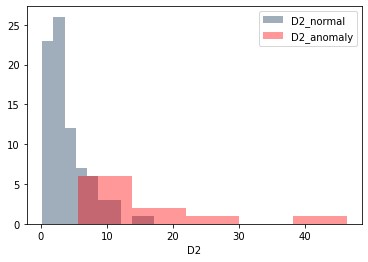

trainデータのT²管理図


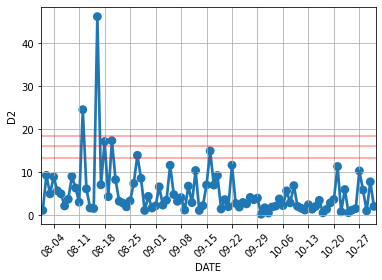

0.1%有意


,D2,DATE
1,24.570604,2020-08-12
2,46.266701,2020-08-16


0.3%有意


,D2,DATE
14,17.153513,2020-08-18
3,17.325807,2020-08-20


1%有意


,D2,DATE
4,13.925234,2020-08-27
40,14.960757,2020-09-16


testデータのT²管理図


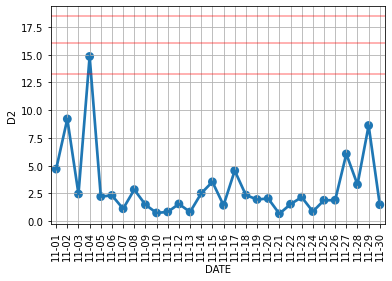

0.1%有意


,D2,DATE


0.3%有意


,D2,DATE


1%有意


,D2,DATE
3,14.83591,2020-11-04


In [13]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from scipy.stats import chi2
import json
import matplotlib.dates as mdates

#標準化
def scal(x,y):
    scaler = StandardScaler()
    scaler.fit(x.iloc[:,1:-1])
    return scaler.transform(y.iloc[:,1:-1])

#逆行列
def cor(x):
    corr = np.corrcoef(x.T)
    return np.linalg.inv(corr)

def mahara(x,y):
    df_D2 = pd.DataFrame(columns = ['D2'])
    for i in range(len(x)):
        a = np.dot(x[i],y)
        d2 = np.dot(a,x[i].T)
        df_D2 = df_D2.append({'D2':d2},ignore_index=True) 
    return df_D2

#データの取得
name = input('name?')
a = open('../.json/anomaly_day.json')
js = json.load(a)
an_days = js[name]

def unit_space(days):
    #trainデータ
    data_tr = pd.read_csv(f'../../data/{name}_train.csv',encoding = 'utf-8', parse_dates = ['日付'])
    data_tr = data_tr[['日付','項目名','値']]
    df = pd.pivot_table(data_tr,index = '日付',columns = '項目名',values = '値')
    df = df.reset_index()
    df = df.interpolate(axis=0)
    df = df.rename(columns = {'日付':'DATE'})
    df = df.drop(['【朝】体重', '【朝】睡眠時間'], axis=1)
    x_clm = df.columns.unique()

    #異常の日を設定
    df['怪我状態'] = 0
    for i in range(len(days)):
        df.loc[df['DATE'] == days[i] , '怪我状態'] = 1


    #normalデータとanomalyデータを作成
    normal = df[df['怪我状態'] == 0].reset_index(drop = True)
    anomaly = df[df['怪我状態'] == 1].reset_index(drop = True)

    #testデータ
    data_ts = pd.read_csv(f'../../data/{name}_test.csv',encoding = 'utf-8', parse_dates = ['日付'])
    data_ts = data_ts[['日付','項目名','値']]
    test = pd.pivot_table(data_ts,index = '日付',columns = '項目名',values = '値')
    test = test.reset_index()
    test = test.interpolate(axis=0)
    test = test.rename(columns = {'日付':'DATE'})
    test = test.drop(['【朝】体重', '【朝】睡眠時間'], axis=1)
    test['怪我状態'] = 0

    #標準化
    scaled_nm = scal(normal,normal)
    scaled_an = scal(normal,anomaly)

    #逆行列
    corr_inv = cor(scaled_nm)

    #マハラノビス距離
    D2 = mahara(scaled_nm,corr_inv) / (len(x_clm)-1)
    D2['DATE'] = normal['DATE']  #ここから異常値を削除して元に戻りたい

    return D2,test,scaled_nm,scaled_an,corr_inv,normal,anomaly,x_clm

#異常値を単位空間から削除
D2,test,scaled_nm,scaled_an,corr_inv,normal,anomaly,x_clm = unit_space(an_days)
a = D2.loc[D2['D2']>3,'DATE']
an_days.extend(a.dt.strftime("%Y-%m-%d").to_list())

#新しい単位空間を作成
D2,test,scaled_nm,scaled_an,corr_inv,normal,anomaly,x_clm = unit_space(an_days)

#L8直行表
df_l8 = pd.DataFrame([[1,1,1,1,1,1,1],[1,1,1,2,2,2,2],[1,2,2,1,1,2,2],[1,2,2,2,2,1,1],[2,1,2,1,2,1,2],[2,1,2,2,1,2,1],[2,2,1,1,2,2,1],[2,2,1,2,1,1,2]])
l8 = (df_l8==1).values

#各異常値のマハラノビス距離
result = np.zeros(shape=(l8.shape[0], scaled_an.shape[0]))
for x, l8_raw in enumerate(l8):
    for y, an_raw in enumerate(scaled_an):
        select_corr = corr_inv[l8_raw][:,l8_raw]
        select_raw = an_raw[l8_raw]
        result[x, y] = np.dot(np.dot(select_raw.reshape(1,-1), select_corr), select_raw) / sum(l8_raw)

#SN比
sn = np.zeros(l8.shape[0])
for idx, raw in enumerate(result):
    a = 0
    for i in range(len(raw)):
        a += 1/np.square(raw[i])
    sn[idx] = -10 * math.log10(a/len(raw))
display(pd.DataFrame(sn,columns = ['SN比']))

#変数選択
df_sn = pd.DataFrame(index = x_clm[1:],columns = ['SN比','残す'])
for i in range(len(x_clm[1:])):
    df_sn.loc[df_sn.index == x_clm[1+i] , 'SN比'] = sum(sn[l8.T[i]])-sum(sn[l8.T[i] == False])
    df_sn.loc[df_sn.index == x_clm[1+i] , '残す'] = sum(sn[l8.T[i]])-sum(sn[l8.T[i] == False])>0
display(df_sn.reset_index())

#変数削除
normal_d = normal.drop(columns=df_sn[df_sn['残す'] == False].index)
anomaly_d = anomaly.drop(columns=df_sn[df_sn['残す'] == False].index)
test_d = test.drop(columns=df_sn[df_sn['残す'] == False].index)

#標準化
scaled_normal_d = scal(normal_d,normal_d)
scaled_anomaly_d = scal(normal_d,anomaly_d)

#逆行列
corr_inv_d = cor(scaled_normal_d)

# 最終的な単位空間からのマハラノビス距離
D2_normal_d = mahara(scaled_normal_d,corr_inv_d)
D2_normal_d['DATE'] = normal['DATE']

print('anomaly')
D2_anomaly_d = mahara(scaled_anomaly_d,corr_inv_d)
D2_anomaly_d['DATE'] = anomaly['DATE']
display(D2_anomaly_d)

#ヒストグラム
ax1 = sns.distplot(
    D2_normal_d['D2'], label='D2_normal',color='#123456',
    kde=False,
    rug=False)
ax2 = sns.distplot(
    D2_anomaly_d['D2'], label='D2_anomaly',color = 'red',
    kde=False,
    rug=False )
plt.legend() 
plt.show()

#χ2検定の棄却域
kai_0_1 = chi2.ppf(q = 0.999,df = df_sn['残す'].sum())
kai_0_3 = chi2.ppf(q = 0.997,df = df_sn['残す'].sum())
kai_1 = chi2.ppf(q = 0.99,df = df_sn['残す'].sum()) 
kai_5 = chi2.ppf(q = 0.95,df = df_sn['残す'].sum()) 

#trainデータのT²管理図
print('trainデータのT²管理図')
D2_train_df = pd.concat([D2_normal_d,D2_anomaly_d])
D2_train_df = D2_train_df.sort_values(['DATE'])
ax = sns.pointplot(x = 'DATE',y = 'D2',data = D2_train_df)
ax.set_xticklabels(D2_train_df["DATE"].dt.strftime("%m-%d"))
ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=None, interval=7, tz=None))
plt.xticks(rotation = 45)
ax.axhline(y = kai_0_1, linewidth=2, color="red",alpha=0.3)
ax.axhline(y = kai_0_3, linewidth=2, color="red",alpha=0.3)
ax.axhline(y = kai_1, linewidth=2, color="red",alpha=0.3)
# ax.axhline(y = kai_5, linewidth=2, color="red",alpha=0.3)
ax.grid()
plt.show()

#0.1%
print("0.1%有意")
display(D2_train_df[D2_train_df['D2'] > kai_0_1])

#0.3%
print("0.3%有意")
display(D2_train_df[(D2_train_df['D2'] > kai_0_3) & (D2_train_df['D2'] < kai_0_1)])

#1%
print("1%有意")
display(D2_train_df[(D2_train_df['D2'] > kai_1) & (D2_train_df['D2'] < kai_0_3)])

# #5%
# print("5%有意")
# display(D2_train_df[(D2_train_df['D2'] > kai_5) & (D2_train_df['D2'] < kai_1)])


#testデータのT²管理図
scaled_test = scal(normal_d,test_d)
D2_test = mahara(scaled_test,corr_inv_d)
D2_test['DATE'] = test['DATE']
print('testデータのT²管理図')
ax = sns.pointplot(x = 'DATE',y = 'D2',data = D2_test)
ax.set_xticklabels(D2_test["DATE"].dt.strftime("%m-%d"))
ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=None, interval=1, tz=None))
plt.xticks(rotation = 90)
ax.axhline(y = kai_0_1, linewidth=2, color="red",alpha=0.3)
ax.axhline(y = kai_0_3, linewidth=2, color="red",alpha=0.3)
ax.axhline(y = kai_1, linewidth=2, color="red",alpha=0.3)
#ax.axhline(y = kai_5, linewidth=2, color="red",alpha=0.3)
ax.grid()
plt.show()

#0.1%
print("0.1%有意")
display(D2_test[D2_test['D2'] > kai_0_1])

#0.3%
print("0.3%有意")
display(D2_test[(D2_test['D2'] > kai_0_3) & (D2_test['D2'] < kai_0_1)])

#1%
print("1%有意")
display(D2_test[(D2_test['D2'] > kai_1) & (D2_test['D2'] < kai_0_3)])

# #5%
# print("5%有意")
# display(D2_test[(D2_test['D2'] > kai_5) & (D2_test['D2'] < kai_1)])



name? namai


,SN比
0,12.991147
1,-29.175750
2,0.471746
3,15.550230
4,15.832474
5,11.952174
6,5.746875
7,13.176763


,項目名,値,残す
0,【全員共通】疲労度,-46.8709,False
1,【朝】下肢の状態,-23.3456,False
2,【朝】体幹の状態,-41.0676,False
3,【朝】疲労度,23.5388,True
4,【朝】睡眠の質,30.638,True
5,【朝】肘の状態,68.5556,True
6,【朝】肩の状態,45.9352,True


anomaly


,D2,DATE
0,36.611433,2020-08-02
1,19.553132,2020-08-05
2,19.751203,2020-08-17
3,33.120151,2020-08-28
4,23.741725,2020-09-04
5,41.620349,2020-09-13
6,42.159365,2020-09-15
7,24.389538,2020-09-28
8,22.150804,2020-10-05
9,58.893920,2020-10-13


C:\Users\baseb\anaconda3\envs\kenkyu\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


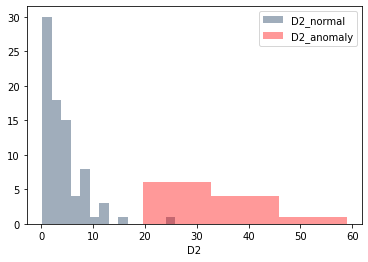

trainデータのT²管理図


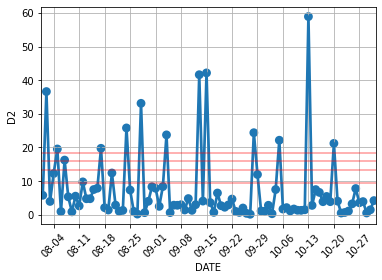

0.1%有意


,D2,DATE
0,36.611433,2020-08-02
1,19.553132,2020-08-05
2,19.751203,2020-08-17
20,25.803805,2020-08-24
3,33.120151,2020-08-28
4,23.741725,2020-09-04
5,41.620349,2020-09-13
6,42.159365,2020-09-15
7,24.389538,2020-09-28
8,22.150804,2020-10-05


0.3%有意


,D2,DATE
0,36.611433,2020-08-02
1,19.553132,2020-08-05
4,16.254636,2020-08-07
2,19.751203,2020-08-17
20,25.803805,2020-08-24
3,33.120151,2020-08-28
4,23.741725,2020-09-04
5,41.620349,2020-09-13
6,42.159365,2020-09-15
7,24.389538,2020-09-28


1%有意


,D2,DATE
0,36.611433,2020-08-02
1,19.553132,2020-08-05
4,16.254636,2020-08-07
2,19.751203,2020-08-17
20,25.803805,2020-08-24
3,33.120151,2020-08-28
4,23.741725,2020-09-04
5,41.620349,2020-09-13
6,42.159365,2020-09-15
7,24.389538,2020-09-28


5%有意


,D2,DATE
2,12.251744,2020-08-04
9,9.775102,2020-08-12
16,12.417426,2020-08-20
51,11.972512,2020-09-29


testデータのT²管理図


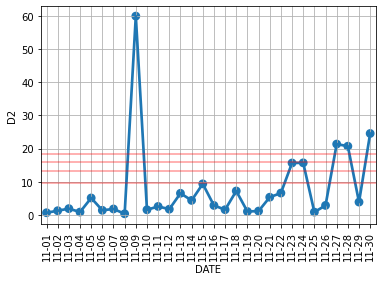

0.1%有意


,D2,DATE
8,60.043173,2020-11-09
26,21.352030,2020-11-27
27,20.701094,2020-11-28
29,24.553790,2020-11-30


0.3%有意


,D2,DATE
8,60.043173,2020-11-09
26,21.352030,2020-11-27
27,20.701094,2020-11-28
29,24.553790,2020-11-30


1%有意


,D2,DATE
8,60.043173,2020-11-09
22,15.628837,2020-11-23
23,15.674521,2020-11-24
26,21.352030,2020-11-27
27,20.701094,2020-11-28
29,24.553790,2020-11-30


5%有意


,D2,DATE


In [11]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from scipy.stats import chi2
import json
import matplotlib.dates as mdates

#標準化
def scal(x,y):
    scaler = StandardScaler()
    scaler.fit(x.iloc[:,1:-1])
    return scaler.transform(y.iloc[:,1:-1])

#逆行列
def cor(x):
    corr = np.corrcoef(x.T)
    return np.linalg.inv(corr)

def mahara(x,y):
    df_D2 = pd.DataFrame(columns = ['D2'])
    for i in range(len(x)):
        a = np.dot(x[i],y)
        d2 = np.dot(a,x[i].T)
        df_D2 = df_D2.append({'D2':d2},ignore_index=True) 
    return df_D2

#データの取得
name = input('name?')
a = open('../.json/anomaly_day.json')
js = json.load(a)
an_days = js[name]

def unit_space(days):
    #trainデータ
    data_tr = pd.read_csv(f'../../data/{name}_train.csv',encoding = 'utf-8', parse_dates = ['日付'])
    data_tr = data_tr[['日付','項目名','値']]
    df = pd.pivot_table(data_tr,index = '日付',columns = '項目名',values = '値')
    df = df.reset_index()
    df = df.interpolate(axis=0)
    df = df.rename(columns = {'日付':'DATE'})
    df = df.drop(['【朝】体重', '【朝】睡眠時間'], axis=1)
    x_clm = df.columns.unique()

    #異常の日を設定
    df['怪我状態'] = 0
    for i in range(len(days)):
        df.loc[df['DATE'] == days[i] , '怪我状態'] = 1


    #normalデータとanomalyデータを作成
    normal = df[df['怪我状態'] == 0].reset_index(drop = True)
    anomaly = df[df['怪我状態'] == 1].reset_index(drop = True)

    #testデータ
    data_ts = pd.read_csv(f'../../data/{name}_test.csv',encoding = 'utf-8', parse_dates = ['日付'])
    data_ts = data_ts[['日付','項目名','値']]
    test = pd.pivot_table(data_ts,index = '日付',columns = '項目名',values = '値')
    test = test.reset_index()
    test = test.interpolate(axis=0)
    test = test.rename(columns = {'日付':'DATE'})
    test = test.drop(['【朝】体重', '【朝】睡眠時間'], axis=1)
    test['怪我状態'] = 0

    #標準化
    scaled_nm = scal(normal,normal)
    scaled_an = scal(normal,anomaly)

    #逆行列
    corr_inv = cor(scaled_nm)

    #マハラノビス距離
    D2 = mahara(scaled_nm,corr_inv) / (len(x_clm)-1)
    D2['DATE'] = normal['DATE']  #ここから異常値を削除して元に戻りたい

    return D2,test,scaled_nm,scaled_an,corr_inv,normal,anomaly,x_clm

#異常値を単位空間から削除
D2,test,scaled_nm,scaled_an,corr_inv,normal,anomaly,x_clm = unit_space(an_days)
a = D2.loc[D2['D2']>3,'DATE']
an_days.extend(a.dt.strftime("%Y-%m-%d").to_list())

#新しい単位空間を作成
D2,test,scaled_nm,scaled_an,corr_inv,normal,anomaly,x_clm = unit_space(an_days)

#L8直行表
df_l8 = pd.DataFrame([[1,1,1,1,1,1,1],[1,1,1,2,2,2,2],[1,2,2,1,1,2,2],[1,2,2,2,2,1,1],[2,1,2,1,2,1,2],[2,1,2,2,1,2,1],[2,2,1,1,2,2,1],[2,2,1,2,1,1,2]])
l8 = (df_l8==1).values

#各異常値のマハラノビス距離
result = np.zeros(shape=(l8.shape[0], scaled_an.shape[0]))
for x, l8_raw in enumerate(l8):
    for y, an_raw in enumerate(scaled_an):
        select_corr = corr_inv[l8_raw][:,l8_raw]
        select_raw = an_raw[l8_raw]
        result[x, y] = np.dot(np.dot(select_raw.reshape(1,-1), select_corr), select_raw) / sum(l8_raw)

#SN比
sn = np.zeros(l8.shape[0])
for idx, raw in enumerate(result):
    a = 0
    for i in range(len(raw)):
        a += 1/np.square(raw[i])
    sn[idx] = -10 * math.log10(a/len(raw))
display(pd.DataFrame(sn,columns = ['SN比']))

#変数選択
df_sn = pd.DataFrame(index = x_clm[1:],columns = ['値','残す'])
for i in range(len(x_clm[1:])):
    df_sn.loc[df_sn.index == x_clm[1+i] , '値'] = sum(sn[l8.T[i]])-sum(sn[l8.T[i] == False])
    df_sn.loc[df_sn.index == x_clm[1+i] , '残す'] = sum(sn[l8.T[i]])-sum(sn[l8.T[i] == False])>0
display(df_sn.reset_index())

#変数削除
normal_d = normal.drop(columns=df_sn[df_sn['残す'] == False].index)
anomaly_d = anomaly.drop(columns=df_sn[df_sn['残す'] == False].index)
test_d = test.drop(columns=df_sn[df_sn['残す'] == False].index)

#標準化
scaled_normal_d = scal(normal_d,normal_d)
scaled_anomaly_d = scal(normal_d,anomaly_d)

#逆行列
corr_inv_d = cor(scaled_normal_d)

# 最終的な単位空間からのマハラノビス距離
D2_normal_d = mahara(scaled_normal_d,corr_inv_d)
D2_normal_d['DATE'] = normal['DATE']

print('anomaly')
D2_anomaly_d = mahara(scaled_anomaly_d,corr_inv_d)
D2_anomaly_d['DATE'] = anomaly['DATE']
display(D2_anomaly_d)

#ヒストグラム
ax1 = sns.distplot(
    D2_normal_d['D2'], label='D2_normal',color='#123456',
    kde=False,
    rug=False)
ax2 = sns.distplot(
    D2_anomaly_d['D2'], label='D2_anomaly',color = 'red',
    kde=False,
    rug=False )
plt.legend() 
plt.show()

#χ2検定の棄却域
kai_0_1 = chi2.ppf(q = 0.999,df = df_sn['残す'].sum())
kai_0_3 = chi2.ppf(q = 0.997,df = df_sn['残す'].sum())
kai_1 = chi2.ppf(q = 0.99,df = df_sn['残す'].sum()) 
kai_5 = chi2.ppf(q = 0.95,df = df_sn['残す'].sum()) 

#trainデータのT²管理図
print('trainデータのT²管理図')
D2_train_df = pd.concat([D2_normal_d,D2_anomaly_d])
D2_train_df = D2_train_df.sort_values(['DATE'])
ax = sns.pointplot(x = 'DATE',y = 'D2',data = D2_train_df)
ax.set_xticklabels(D2_train_df["DATE"].dt.strftime("%m-%d"))
ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=None, interval=7, tz=None))
plt.xticks(rotation = 45)
ax.axhline(y = kai_0_1, linewidth=2, color="red",alpha=0.3)
ax.axhline(y = kai_0_3, linewidth=2, color="red",alpha=0.3)
ax.axhline(y = kai_1, linewidth=2, color="red",alpha=0.3)
ax.axhline(y = kai_5, linewidth=2, color="red",alpha=0.3)
ax.grid()
plt.show()

#0.1%
print("0.1%有意")
display(D2_train_df[D2_train_df['D2'] > kai_0_1])

#0.3%
print("0.3%有意")
display(D2_train_df[D2_train_df['D2'] > kai_0_3])

#1%
print("1%有意")
display(D2_train_df[D2_train_df['D2'] > kai_1])

#5%
print("5%有意")
display(D2_train_df[(D2_train_df['D2'] > kai_5) & (D2_train_df['D2'] < kai_1)])


#testデータのT²管理図
scaled_test = scal(normal_d,test_d)
D2_test = mahara(scaled_test,corr_inv_d)
D2_test['DATE'] = test['DATE']
print('testデータのT²管理図')
ax = sns.pointplot(x = 'DATE',y = 'D2',data = D2_test)
ax.set_xticklabels(D2_test["DATE"].dt.strftime("%m-%d"))
ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=None, interval=1, tz=None))
plt.xticks(rotation = 90)
ax.axhline(y = kai_0_1, linewidth=2, color="red",alpha=0.3)
ax.axhline(y = kai_0_3, linewidth=2, color="red",alpha=0.3)
ax.axhline(y = kai_1, linewidth=2, color="red",alpha=0.3)
ax.axhline(y = kai_5, linewidth=2, color="red",alpha=0.3)
ax.grid()
plt.show()

#0.1%
print("0.1%有意")
display(D2_test[D2_test['D2'] > kai_0_1])

#0.3%
print("0.3%有意")
display(D2_test[D2_test['D2'] > kai_0_3])

#1%
print("1%有意")
display(D2_test[D2_test['D2'] > kai_1])

#5%
print("5%有意")
display(D2_test[(D2_test['D2'] > kai_5) & (D2_test['D2'] < kai_1)])



name? masui


,SN比
0,4.613900
1,-7.561521
2,3.701515
3,7.511275
4,5.336167
5,8.999664
6,7.455928
7,6.892722


,項目名,値,残す
0,【全員共通】疲労度,-20.4193,False
1,【朝】下肢の状態,-14.1732,False
2,【朝】体幹の状態,-14.1476,False
3,【朝】疲労度,5.26537,True
4,【朝】睡眠の質,11.466,True
5,【朝】肘の状態,11.7585,True
6,【朝】肩の状態,20.2119,True


anomaly


,D2,DATE
0,9.264757,2020-08-02
1,24.570604,2020-08-12
2,46.266701,2020-08-16
3,17.325807,2020-08-20
4,13.925234,2020-08-27
5,6.584941,2020-09-02
6,6.972324,2020-09-17
7,11.630193,2020-09-22
8,5.649401,2020-10-07
9,10.297568,2020-10-27


C:\Users\baseb\anaconda3\envs\kenkyu\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


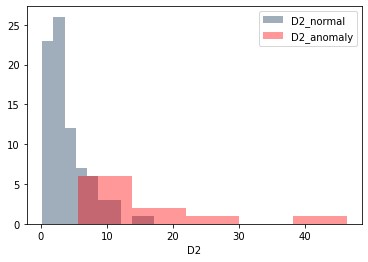

trainデータのT²管理図


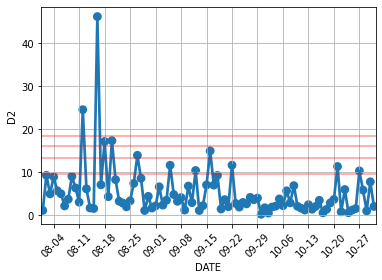

0.1%有意


,D2,DATE
1,24.570604,2020-08-12
2,46.266701,2020-08-16


0.3%有意


,D2,DATE
1,24.570604,2020-08-12
2,46.266701,2020-08-16
14,17.153513,2020-08-18
3,17.325807,2020-08-20


1%有意


,D2,DATE
1,24.570604,2020-08-12
2,46.266701,2020-08-16
14,17.153513,2020-08-18
3,17.325807,2020-08-20
4,13.925234,2020-08-27
40,14.960757,2020-09-16


5%有意


,D2,DATE
29,11.618617,2020-09-05
36,10.385244,2020-09-12
7,11.630193,2020-09-22
72,11.322370,2020-10-21
9,10.297568,2020-10-27


testデータのT²管理図


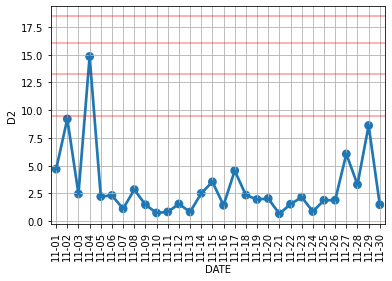

0.1%有意


,D2,DATE


0.3%有意


,D2,DATE


1%有意


,D2,DATE
3,14.83591,2020-11-04


5%有意


,D2,DATE


In [12]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from scipy.stats import chi2
import json
import matplotlib.dates as mdates

#標準化
def scal(x,y):
    scaler = StandardScaler()
    scaler.fit(x.iloc[:,1:-1])
    return scaler.transform(y.iloc[:,1:-1])

#逆行列
def cor(x):
    corr = np.corrcoef(x.T)
    return np.linalg.inv(corr)

def mahara(x,y):
    df_D2 = pd.DataFrame(columns = ['D2'])
    for i in range(len(x)):
        a = np.dot(x[i],y)
        d2 = np.dot(a,x[i].T)
        df_D2 = df_D2.append({'D2':d2},ignore_index=True) 
    return df_D2

#データの取得
name = input('name?')
a = open('../.json/anomaly_day.json')
js = json.load(a)
an_days = js[name]

def unit_space(days):
    #trainデータ
    data_tr = pd.read_csv(f'../../data/{name}_train.csv',encoding = 'utf-8', parse_dates = ['日付'])
    data_tr = data_tr[['日付','項目名','値']]
    df = pd.pivot_table(data_tr,index = '日付',columns = '項目名',values = '値')
    df = df.reset_index()
    df = df.interpolate(axis=0)
    df = df.rename(columns = {'日付':'DATE'})
    df = df.drop(['【朝】体重', '【朝】睡眠時間'], axis=1)
    x_clm = df.columns.unique()

    #異常の日を設定
    df['怪我状態'] = 0
    for i in range(len(days)):
        df.loc[df['DATE'] == days[i] , '怪我状態'] = 1


    #normalデータとanomalyデータを作成
    normal = df[df['怪我状態'] == 0].reset_index(drop = True)
    anomaly = df[df['怪我状態'] == 1].reset_index(drop = True)

    #testデータ
    data_ts = pd.read_csv(f'../../data/{name}_test.csv',encoding = 'utf-8', parse_dates = ['日付'])
    data_ts = data_ts[['日付','項目名','値']]
    test = pd.pivot_table(data_ts,index = '日付',columns = '項目名',values = '値')
    test = test.reset_index()
    test = test.interpolate(axis=0)
    test = test.rename(columns = {'日付':'DATE'})
    test = test.drop(['【朝】体重', '【朝】睡眠時間'], axis=1)
    test['怪我状態'] = 0

    #標準化
    scaled_nm = scal(normal,normal)
    scaled_an = scal(normal,anomaly)

    #逆行列
    corr_inv = cor(scaled_nm)

    #マハラノビス距離
    D2 = mahara(scaled_nm,corr_inv) / (len(x_clm)-1)
    D2['DATE'] = normal['DATE']  #ここから異常値を削除して元に戻りたい

    return D2,test,scaled_nm,scaled_an,corr_inv,normal,anomaly,x_clm

#異常値を単位空間から削除
D2,test,scaled_nm,scaled_an,corr_inv,normal,anomaly,x_clm = unit_space(an_days)
a = D2.loc[D2['D2']>3,'DATE']
an_days.extend(a.dt.strftime("%Y-%m-%d").to_list())

#新しい単位空間を作成
D2,test,scaled_nm,scaled_an,corr_inv,normal,anomaly,x_clm = unit_space(an_days)

#L8直行表
df_l8 = pd.DataFrame([[1,1,1,1,1,1,1],[1,1,1,2,2,2,2],[1,2,2,1,1,2,2],[1,2,2,2,2,1,1],[2,1,2,1,2,1,2],[2,1,2,2,1,2,1],[2,2,1,1,2,2,1],[2,2,1,2,1,1,2]])
l8 = (df_l8==1).values

#各異常値のマハラノビス距離
result = np.zeros(shape=(l8.shape[0], scaled_an.shape[0]))
for x, l8_raw in enumerate(l8):
    for y, an_raw in enumerate(scaled_an):
        select_corr = corr_inv[l8_raw][:,l8_raw]
        select_raw = an_raw[l8_raw]
        result[x, y] = np.dot(np.dot(select_raw.reshape(1,-1), select_corr), select_raw) / sum(l8_raw)

#SN比
sn = np.zeros(l8.shape[0])
for idx, raw in enumerate(result):
    a = 0
    for i in range(len(raw)):
        a += 1/np.square(raw[i])
    sn[idx] = -10 * math.log10(a/len(raw))
display(pd.DataFrame(sn,columns = ['SN比']))

#変数選択
df_sn = pd.DataFrame(index = x_clm[1:],columns = ['値','残す'])
for i in range(len(x_clm[1:])):
    df_sn.loc[df_sn.index == x_clm[1+i] , '値'] = sum(sn[l8.T[i]])-sum(sn[l8.T[i] == False])
    df_sn.loc[df_sn.index == x_clm[1+i] , '残す'] = sum(sn[l8.T[i]])-sum(sn[l8.T[i] == False])>0
display(df_sn.reset_index())

#変数削除
normal_d = normal.drop(columns=df_sn[df_sn['残す'] == False].index)
anomaly_d = anomaly.drop(columns=df_sn[df_sn['残す'] == False].index)
test_d = test.drop(columns=df_sn[df_sn['残す'] == False].index)

#標準化
scaled_normal_d = scal(normal_d,normal_d)
scaled_anomaly_d = scal(normal_d,anomaly_d)

#逆行列
corr_inv_d = cor(scaled_normal_d)

# 最終的な単位空間からのマハラノビス距離
D2_normal_d = mahara(scaled_normal_d,corr_inv_d)
D2_normal_d['DATE'] = normal['DATE']

print('anomaly')
D2_anomaly_d = mahara(scaled_anomaly_d,corr_inv_d)
D2_anomaly_d['DATE'] = anomaly['DATE']
display(D2_anomaly_d)

#ヒストグラム
ax1 = sns.distplot(
    D2_normal_d['D2'], label='D2_normal',color='#123456',
    kde=False,
    rug=False)
ax2 = sns.distplot(
    D2_anomaly_d['D2'], label='D2_anomaly',color = 'red',
    kde=False,
    rug=False )
plt.legend() 
plt.show()

#χ2検定の棄却域
kai_0_1 = chi2.ppf(q = 0.999,df = df_sn['残す'].sum())
kai_0_3 = chi2.ppf(q = 0.997,df = df_sn['残す'].sum())
kai_1 = chi2.ppf(q = 0.99,df = df_sn['残す'].sum()) 
kai_5 = chi2.ppf(q = 0.95,df = df_sn['残す'].sum()) 

#trainデータのT²管理図
print('trainデータのT²管理図')
D2_train_df = pd.concat([D2_normal_d,D2_anomaly_d])
D2_train_df = D2_train_df.sort_values(['DATE'])
ax = sns.pointplot(x = 'DATE',y = 'D2',data = D2_train_df)
ax.set_xticklabels(D2_train_df["DATE"].dt.strftime("%m-%d"))
ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=None, interval=7, tz=None))
plt.xticks(rotation = 45)
ax.axhline(y = kai_0_1, linewidth=2, color="red",alpha=0.3)
ax.axhline(y = kai_0_3, linewidth=2, color="red",alpha=0.3)
ax.axhline(y = kai_1, linewidth=2, color="red",alpha=0.3)
ax.axhline(y = kai_5, linewidth=2, color="red",alpha=0.3)
ax.grid()
plt.show()

#0.1%
print("0.1%有意")
display(D2_train_df[D2_train_df['D2'] > kai_0_1])

#0.3%
print("0.3%有意")
display(D2_train_df[D2_train_df['D2'] > kai_0_3])

#1%
print("1%有意")
display(D2_train_df[D2_train_df['D2'] > kai_1])

#5%
print("5%有意")
display(D2_train_df[(D2_train_df['D2'] > kai_5) & (D2_train_df['D2'] < kai_1)])


#testデータのT²管理図
scaled_test = scal(normal_d,test_d)
D2_test = mahara(scaled_test,corr_inv_d)
D2_test['DATE'] = test['DATE']
print('testデータのT²管理図')
ax = sns.pointplot(x = 'DATE',y = 'D2',data = D2_test)
ax.set_xticklabels(D2_test["DATE"].dt.strftime("%m-%d"))
ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=None, interval=1, tz=None))
plt.xticks(rotation = 90)
ax.axhline(y = kai_0_1, linewidth=2, color="red",alpha=0.3)
ax.axhline(y = kai_0_3, linewidth=2, color="red",alpha=0.3)
ax.axhline(y = kai_1, linewidth=2, color="red",alpha=0.3)
ax.axhline(y = kai_5, linewidth=2, color="red",alpha=0.3)
ax.grid()
plt.show()

#0.1%
print("0.1%有意")
display(D2_test[D2_test['D2'] > kai_0_1])

#0.3%
print("0.3%有意")
display(D2_test[D2_test['D2'] > kai_0_3])

#1%
print("1%有意")
display(D2_test[D2_test['D2'] > kai_1])

#5%
print("5%有意")
display(D2_test[(D2_test['D2'] > kai_5) & (D2_test['D2'] < kai_1)])

